In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Création du générateur**

In [3]:
base_sure_directory = '/content/drive/MyDrive/base_sure_enrish'

### **Le générateur**

In [4]:
import os
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

def extract_label_from_filename(filename):
    # Exemple : on extrait un label à partir du nom du fichier
    # À adapter selon votre logique
    return int(filename.split('-')[1].split('_')[0])

class ImageLabelGenerator(Sequence):
    def __init__(self, image_dir, image_filenames, batch_size=32, target_size=(300, 300), shuffle=True, augment=False):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        # Retourne le nombre de lots par epoch
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []

        for filename in batch_filenames:
            label = extract_label_from_filename(filename)
            img_path = os.path.join(self.image_dir, filename)
            image = load_img(img_path, target_size=self.target_size)
            image = img_to_array(image)

            # Appliquer la data augmentation si activée
            if self.augment:
                image = self.random_transform(image)

            # Appliquer le prétraitement attendu par le modèle pré-entraîné
            image = preprocess_input(image)
            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def random_transform(self, image):
        # Convertir l'image en tenseur pour appliquer les transformations
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

        # Flip horizontal aléatoire
        if random.random() < 0.5:
            image_tensor = tf.image.flip_left_right(image_tensor)

        # Variation de luminosité aléatoire
        image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.1)

        # Variation de contraste aléatoire
        image_tensor = tf.image.random_contrast(image_tensor, lower=0.8, upper=1.2)

        # Rotation aléatoire entre -20° et +20° via la couche RandomRotation
        rotation_layer = tf.keras.layers.RandomRotation(factor=20/360, fill_mode='reflect')
        image_tensor = rotation_layer(tf.expand_dims(image_tensor, axis=0))[0]

        # Zoom aléatoire :
        # On choisit un facteur entre 0.8 et 1.0, on recadre puis redimensionne à la taille originale
        scale = random.uniform(0.8, 1.0)
        h, w, c = image_tensor.shape
        new_h = tf.cast(scale * h, tf.int32)
        new_w = tf.cast(scale * w, tf.int32)
        image_tensor = tf.image.random_crop(image_tensor, size=[new_h, new_w, c])
        image_tensor = tf.image.resize(image_tensor, [h, w])

        return image_tensor.numpy()


In [5]:
all_images = [f for f in os.listdir(base_sure_directory) if f.endswith('.jpg')]

train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42, shuffle=True)

train_generator = ImageLabelGenerator(base_sure_directory, train_files, batch_size=32, augment=True)
val_generator = ImageLabelGenerator(base_sure_directory, val_files, batch_size=32, shuffle=False, augment=False)

In [ ]:
print(train_generator.__len__())
print(val_generator.__len__())

1066
267


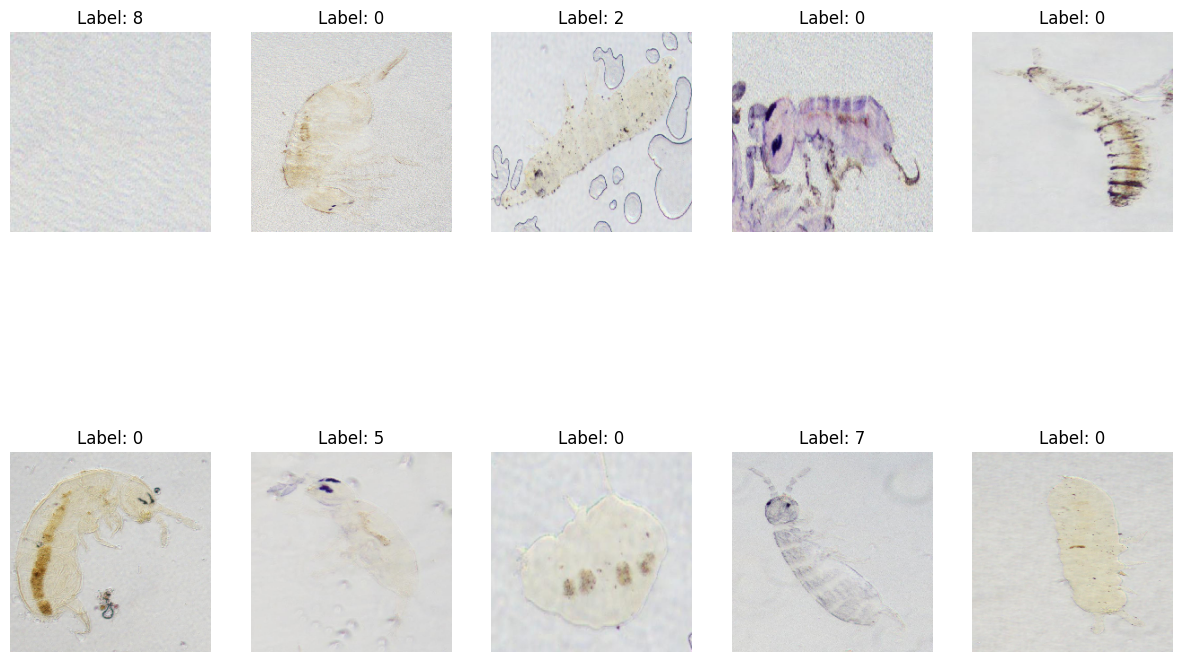

In [ ]:
images, labels = train_generator[0]

# Afficher 10 images du dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 lignes et 5 colonnes pour afficher 10 images
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')  # Désactive l'affichage des axes
plt.show()

In [ ]:
train_labels = []
for batch_images, batch_labels in train_generator:
    train_labels.extend(batch_labels)

train_labels = np.array(train_labels)
unique_train_labels = np.unique(train_labels)

# Extraire les labels uniques du générateur de validation
val_labels = []
for batch_images, batch_labels in val_generator:
    val_labels.extend(batch_labels)


val_labels = np.array(val_labels)
unique_val_labels = np.unique(val_labels)

print("Classes présentes dans l'entraînement (train):", unique_train_labels)
print("Classes présentes dans la validation (val):", unique_val_labels)

print(f"Nombre de classes dans l'entraînement : {len(unique_train_labels)}")
print(f"Nombre de classes dans la validation : {len(unique_val_labels)}")

# Modèle 2

In [ ]:
!pip install tensorflow-addons --upgrade


In [ ]:
!pip install tensorflow==2.15


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uni

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Couche InstanceNormalization personnalisée (pour éviter tensorflow_addons)
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale', shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1.0, 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset', shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

# Définition du nombre de classes à partir de vos labels uniques
num_classes = 9

# Base MobileNetV2 pré-entraînée sans la partie classification
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning : débloquer les 20 dernières couches
#for layer in base_model.layers[:]:
 #   layer.trainable = True

# Construction du modèle
x = base_model.output

# Bloc convolutionnel 1 avec InstanceNormalization
x = Conv2D(128, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)

# Bloc convolutionnel 2 avec InstanceNormalization
x = Conv2D(128, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)

# Bloc convolutionnel 3 avec InstanceNormalization
x = Conv2D(256, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)

# Réduction de la dimension spatiale
x = GlobalAveragePooling2D()(x)

# Dropout pour régulariser
x = Dropout(0.5)(x)

# Couche de sortie avec softmax pour la classification
predictions = Dense(num_classes, activation='softmax')(x)

# Construction du modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

# Calculer le nombre de steps par époque en se basant sur le nombre d'images complètes dans chaque ensemble
batch_size = 32
steps_per_epoch = int(np.floor(len(train_files) / batch_size))
validation_steps = int(np.floor(len(val_files) / batch_size))

print("Total images train :", len(train_files))
print("Steps par époque pour l'entraînement :", steps_per_epoch)
print("Total images val   :", len(val_files))
print("Steps par époque pour la validation :", validation_steps)

# Pour éviter que le générateur ne yield des lots vides, on crée un wrapper qui limite le nombre de lots
def limited_generator(generator, steps):
    for i in range(steps):
        yield generator[i]

train_gen_wrapper = limited_generator(train_generator, steps_per_epoch)
val_gen_wrapper = limited_generator(val_generator, validation_steps)

# Entraînement du modèle
history = model.fit(
    train_gen_wrapper,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen_wrapper,
    validation_steps=validation_steps,
    epochs=50
)


Total images train : 1066
Steps par époque pour l'entraînement : 33
Total images val   : 267
Steps par époque pour la validation : 8
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.0929 - loss: 2.4593 - val_accuracy: 0.0977 - val_loss: 2.2031
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0469 - val_loss: 2.2309
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.1553 - loss: 2.2934 - val_accuracy: 0.0469 - val_loss: 2.2220
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.0606 - loss: 2.3762 - val_accuracy: 0.0469 - val_loss: 2.2116
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.2178 - loss: 2.1585 - val_accuracy: 0.0469 - val_loss: 2.1997
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.1572 - loss: 2.1318 - val_accuracy: 0.0469 - val_loss: 2.1896
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.2197 - loss: 2.1642 - val_

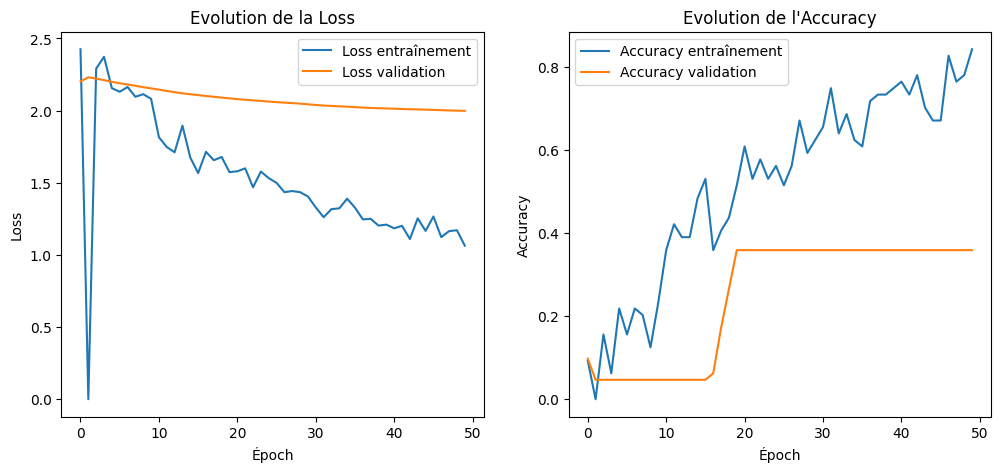

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de la loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Evolution de la Loss')
plt.xlabel('Époch')
plt.ylabel('Loss')
plt.legend()

# Tracer la courbe de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Époch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Couche InstanceNormalization personnalisée (pour éviter tensorflow_addons)
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale', shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1.0, 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset', shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

# Nombre de classes
num_classes = 9

# Base MobileNetV2 pré-entraînée sans la partie classification
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning : ne rendre entraînables que les 20 dernières couches
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Construction du modèle
x = base_model.output

# Bloc convolutionnel 1 avec InstanceNormalization + Dropout
x = Conv2D(128, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)  # Dropout supplémentaire pour régulariser

# Bloc convolutionnel 2 avec InstanceNormalization + Dropout
x = Conv2D(128, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Bloc convolutionnel 3 avec InstanceNormalization + Dropout
x = Conv2D(256, (3, 3), padding='same')(x)
x = InstanceNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# Réduction de la dimension spatiale
x = GlobalAveragePooling2D()(x)

# Dropout pour la couche de sortie
x = Dropout(0.5)(x)

# Couche de sortie avec softmax pour la classification
predictions = Dense(num_classes, activation='softmax')(x)

# Construction du modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping pour stopper l'entraînement quand la validation n'améliore plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculer steps_per_epoch et validation_steps pour éviter l'erreur de lots vides
batch_size = 32
steps_per_epoch = int(np.floor(len(train_files) / batch_size))
validation_steps = int(np.floor(len(val_files) / batch_size))

print("Total images train :", len(train_files))
print("Steps par époque pour l'entraînement :", steps_per_epoch)
print("Total images val   :", len(val_files))
print("Steps par époque pour la validation :", validation_steps)

# Wrapper pour limiter le nombre de lots générés
def limited_generator(generator, steps):
    for i in range(steps):
        yield generator[i]

train_gen_wrapper = limited_generator(train_generator, steps_per_epoch)
val_gen_wrapper = limited_generator(val_generator, validation_steps)

# Entraînement du modèle
history = model.fit(
    train_gen_wrapper,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen_wrapper,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stop]  # On ajoute EarlyStopping ici
)


Total images train : 1066
Steps par époque pour l'entraînement : 33
Total images val   : 267
Steps par époque pour la validation : 8
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1296 - loss: 2.3956 - val_accuracy: 0.1289 - val_loss: 2.1895
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0938 - val_loss: 2.1680
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.1259 - loss: 2.4099 - val_accuracy: 0.0938 - val_loss: 2.1590
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.1411 - loss: 2.2990 - val_accuracy: 0.0938 - val_loss: 2.1503
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2027 - loss: 2.2014 - val_accuracy: 0.0938 - val_loss: 2.1414
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.1117 - loss: 2.2860 - val_accuracy: 0.0938 - val_loss: 2.1327
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.1591 - loss: 2.3127 - val_accura

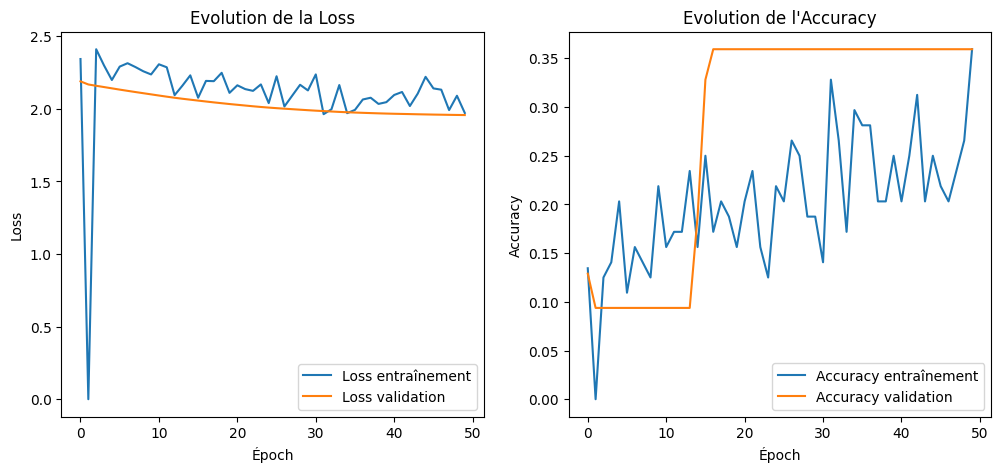

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de la loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Evolution de la Loss')
plt.xlabel('Époch')
plt.ylabel('Loss')
plt.legend()

# Tracer la courbe de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Époch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Paramètres
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# 1. Charger MobileNetV2 sans la tête de classification
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Geler toutes les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# 3. Construire une tête de classification personnalisée
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    # Ajouter du Dropout et de la régularisation L2 pour réduire l'overfitting
    layers.Dropout(0.5),
    layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Mettre en place EarlyStopping pour arrêter quand la validation n’améliore plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. Calculer le nombre de steps par époque et de validation
steps_per_epoch = int(np.floor(len(train_files) / BATCH_SIZE))
validation_steps = int(np.floor(len(val_files) / BATCH_SIZE))

print("Total images train :", len(train_files))
print("Steps par époque pour l'entraînement :", steps_per_epoch)
print("Total images val   :", len(val_files))
print("Steps par époque pour la validation :", validation_steps)

# 7. Limiter le générateur à ces steps pour éviter les lots vides
def limited_generator(generator, steps):
    for i in range(steps):
        yield generator[i]

train_gen_wrapper = limited_generator(train_generator, steps_per_epoch)
val_gen_wrapper = limited_generator(val_generator, validation_steps)

# 8. Entraîner le modèle
history = model.fit(
    train_gen_wrapper,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen_wrapper,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stop]
)


Total images train : 1066
Steps par époque pour l'entraînement : 33
Total images val   : 267
Steps par époque pour la validation : 8
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1236 - loss: 3.7827 - val_accuracy: 0.2891 - val_loss: 2.2313
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3438 - val_loss: 2.1718
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2775 - loss: 2.7446 - val_accuracy: 0.3438 - val_loss: 2.1624
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2348 - loss: 3.0442 - val_accuracy: 0.3438 - val_loss: 2.1511
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.1866 - loss: 3.2050 - val_accuracy: 0.3438 - val_loss: 2.1377
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2188 - loss: 2.9557 - val_accuracy: 0.3438 - val_loss: 2.1217
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.2017 - loss: 3.0706 - val_accurac

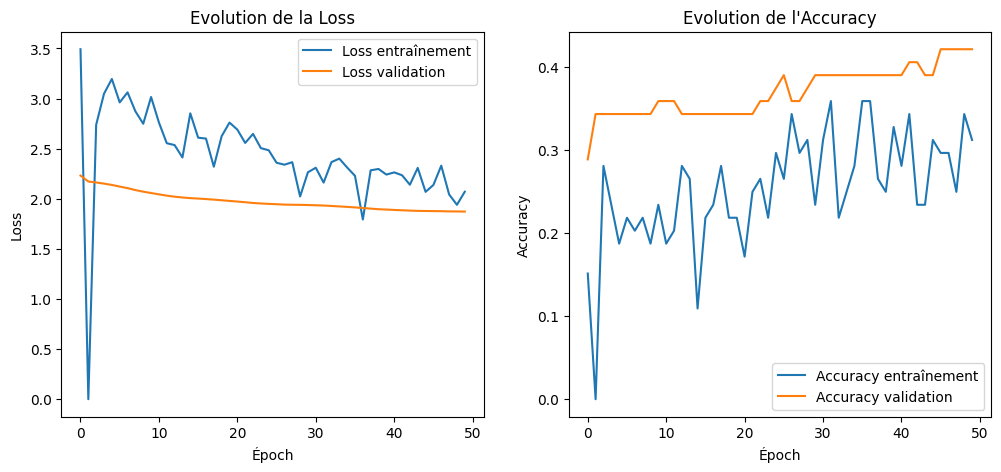

In [ ]:
import matplotlib.pyplot as plt

# Tracer la courbe de la loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.title('Evolution de la Loss')
plt.xlabel('Époch')
plt.ylabel('Loss')
plt.legend()

# Tracer la courbe de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Époch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Paramètres
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# Chargement de MobileNetV2 sans la tête de classification (include_top=False)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)


# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter une tête de classification personnalisée
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Mettre en place EarlyStopping pour arrêter quand la validation n’améliore plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. Calculer le nombre de steps par époque et de validation
steps_per_epoch = int(np.floor(len(train_files) / BATCH_SIZE))
validation_steps = int(np.floor(len(val_files) / BATCH_SIZE))

print("Total images train :", len(train_files))
print("Steps par époque pour l'entraînement :", steps_per_epoch)
print("Total images val   :", len(val_files))
print("Steps par époque pour la validation :", validation_steps)

# 7. Limiter le générateur à ces steps pour éviter les lots vides
def limited_generator(generator, steps):
    for i in range(steps):
        yield generator[i]

train_gen_wrapper = limited_generator(train_generator, steps_per_epoch)
val_gen_wrapper = limited_generator(val_generator, validation_steps)

# 8. Entraîner le modèle
history = model.fit(
    train_gen_wrapper,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen_wrapper,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stop]
)


Total images train : 1066
Steps par époque pour l'entraînement : 33
Total images val   : 267
Steps par époque pour la validation : 8
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 998ms/step - accuracy: 0.1842 - loss: 2.5484 - val_accuracy: 0.2695 - val_loss: 2.0005
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2812 - val_loss: 1.9405
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2642 - loss: 2.2724 - val_accuracy: 0.2969 - val_loss: 1.9252
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3134 - loss: 1.9647 - val_accuracy: 0.3438 - val_loss: 1.9111
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3277 - loss: 2.0366 - val_accuracy: 0.3438 - val_loss: 1.8999
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3286 - loss: 2.0422 - val_accuracy: 0.3594 - val_loss: 1.8929
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2661 - loss: 2.0303 - val_accu

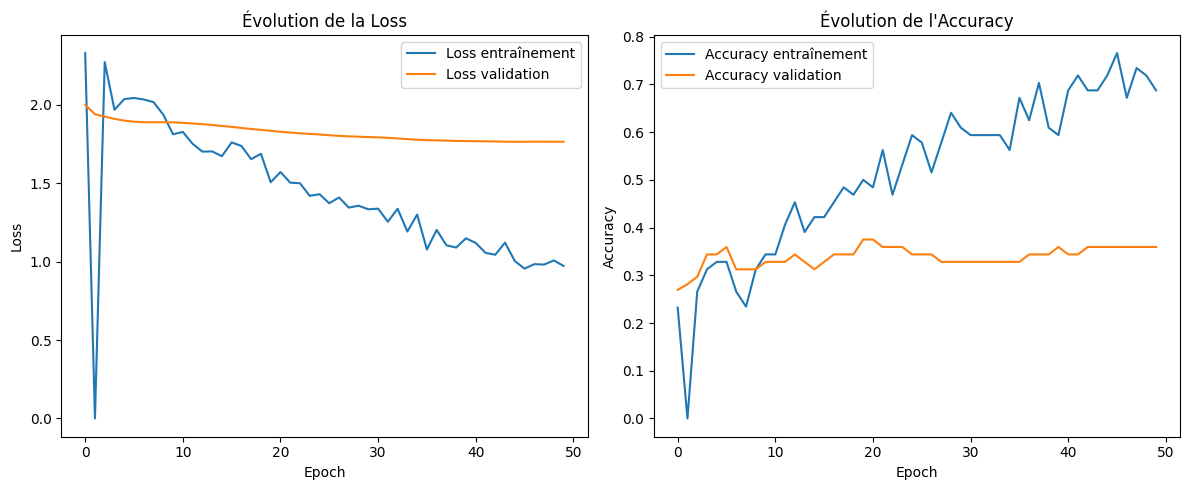

In [ ]:
import matplotlib.pyplot as plt

# Tracer la Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()

# Tracer l'Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ========= 1. Préparation des images de test =========
# Chemin du dossier original contenant vos images de test (sans label dans le nom)
test_dir = '/content/drive/MyDrive/CHALLANGE IA/datatest'

# Chemin vers un dossier temporaire où l'on va copier les images en y ajoutant un label factice
temp_test_dir = '/content/drive/MyDrive/CHALLANGE IA/temp_test'
if not os.path.exists(temp_test_dir):
    os.makedirs(temp_test_dir)

# Lister les fichiers de test (par exemple, ceux se terminant par .jpg)
original_test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])

# Créer une nouvelle liste de noms en y ajoutant un label factice (ici "0")
# Exemple : "image1.jpg" -> "image1-0_.jpg"
renamed_test_filenames = []
for filename in original_test_filenames:
    base = os.path.splitext(filename)[0]
    new_filename = f"{base}-0_.jpg"  # label factice : 0
    renamed_test_filenames.append(new_filename)
    # Copier le fichier dans le dossier temporaire avec le nouveau nom
    shutil.copy(os.path.join(test_dir, filename), os.path.join(temp_test_dir, new_filename))

# ========= 2. Créer le générateur de test en utilisant votre classe existante =========
# On utilise votre générateur sans le modifier
test_generator = ImageLabelGenerator(
    image_dir=temp_test_dir,
    image_filenames=renamed_test_filenames,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False
)

# ========= 3. Prédire avec votre modèle =========
# La fonction model.predict utilisera le générateur.
preds_proba = model.predict(test_generator, steps=int(np.ceil(len(renamed_test_filenames) / 32)))
preds_classes = np.argmax(preds_proba, axis=1)

# ========= 4. Convertir les indices en labels lisibles =========
# Comme votre générateur ne possède pas .class_indices, on définit le mapping manuellement.
# Ici, on suppose que vos labels sont des entiers allant de 0 à NUM_CLASSES-1.
NUM_CLASSES = 9
inv_class_indices = {i: str(i) for i in range(NUM_CLASSES)}
predicted_labels = [inv_class_indices[idx] for idx in preds_classes]

# ========= 5. Créer et sauvegarder le fichier CSV de soumission =========
# On utilise les noms originaux (sans label factice) pour l'indexation
submission_df = pd.DataFrame({
    'idx': [os.path.splitext(f)[0] for f in original_test_filenames],
    'gt': predicted_labels
})

submission_csv_path = '/content/drive/MyDrive/CHALLANGE IA/SUB3.csv'
submission_df.to_csv(submission_csv_path, index=False)

print("Prédictions sur la base incertaine :")
print(submission_df.head())


42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 793ms/step
Prédictions sur la base incertaine :
                                                 idx gt
0  0.000287271854623405430.157444760850390830.996...  0
1  0.0010863036917236890.47680670826091410.132699...  0
2  0.00353289859414340770.76539580712550110.01220...  0
3  0.0042943058174115260.7384949814241050.9756010...  0
4  0.0046691375801363180.53378260284225820.730659...  7


# Modele 0.28

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Paramètres du modèle
IMG_HEIGHT = 300
IMG_WIDTH = 300
NUM_CLASSES = 9
BATCH_SIZE = 32

# --- Phase 1 : Chargement du modèle de base et entraînement de la tête ---

# Charger MobileNetV2 sans la tête (include_top=False) avec les poids ImageNet
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Geler les couches du modèle de base pour ne pas les entraîner dans un premier temps
for layer in base_model.layers:
    layer.trainable = False

# Construire le modèle en ajoutant une tête de classification personnalisée
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compiler le modèle avec un learning rate plus élevé pour la phase 1
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour surveiller l'entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraîner le modèle (Phase 1) avec ton générateur d'entraînement et de validation
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# --- Phase 2 : Fine-tuning du modèle de base ---

# Débloquer les 30 dernières couches de MobileNetV2 pour affiner le modèle
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompiler le modèle avec un learning rate réduit pour éviter des modifications trop brutales
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Poursuivre l'entraînement (Phase 2) avec le fine-tuning
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# Évaluation finale du modèle sur le jeu de validation
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


<ipython-input-7-ba079ebddbea>:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.2675 - loss: 2.0962 - val_accuracy: 0.3646 - val_loss: 1.8418 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.3838 - loss: 1.7593 - val_accuracy: 0.3403 - val_loss: 1.8276 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.3967 - loss: 1.6400 - val_accuracy: 0.3854 - val_loss: 1.7890 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.4498 - loss: 1.5440 - val_accuracy: 0.4028 - val_loss: 1.6725 - learning_rate: 0.0010
Epoch 5/10
21/38 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.4706 - loss: 1.5388

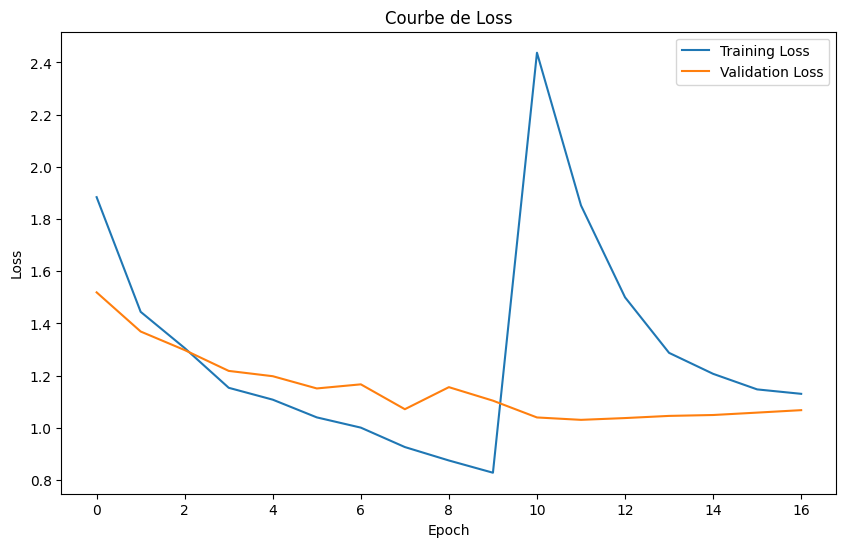

In [ ]:
import matplotlib.pyplot as plt

# Combinaison des courbes de perte des deux phases
train_loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ========= 1. Préparation des images de test =========
# Chemin du dossier original contenant vos images de test (sans label dans le nom)
test_dir = '/content/drive/MyDrive/CHALLANGE IA/datatest'

# Chemin vers un dossier temporaire où l'on va copier les images en y ajoutant un label factice
temp_test_dir = '/content/drive/MyDrive/CHALLANGE IA/temp_test'
if not os.path.exists(temp_test_dir):
    os.makedirs(temp_test_dir)

# Lister les fichiers de test (par exemple, ceux se terminant par .jpg)
original_test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])

# Créer une nouvelle liste de noms en y ajoutant un label factice (ici "0")
# Exemple : "image1.jpg" -> "image1-0_.jpg"
renamed_test_filenames = []
for filename in original_test_filenames:
    base = os.path.splitext(filename)[0]
    new_filename = f"{base}-0_.jpg"  # label factice : 0
    renamed_test_filenames.append(new_filename)
    # Copier le fichier dans le dossier temporaire avec le nouveau nom
    shutil.copy(os.path.join(test_dir, filename), os.path.join(temp_test_dir, new_filename))

# ========= 2. Créer le générateur de test en utilisant votre classe existante =========
# On utilise votre générateur sans le modifier
test_generator = ImageLabelGenerator(
    image_dir=temp_test_dir,
    image_filenames=renamed_test_filenames,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False
)

# ========= 3. Prédire avec votre modèle =========
# La fonction model.predict utilisera le générateur.
preds_proba = model.predict(test_generator, steps=int(np.ceil(len(renamed_test_filenames) / 32)))
preds_classes = np.argmax(preds_proba, axis=1)

# ========= 4. Convertir les indices en labels lisibles =========
# Comme votre générateur ne possède pas .class_indices, on définit le mapping manuellement.
# Ici, on suppose que vos labels sont des entiers allant de 0 à NUM_CLASSES-1.
NUM_CLASSES = 9
inv_class_indices = {i: str(i) for i in range(NUM_CLASSES)}
predicted_labels = [inv_class_indices[idx] for idx in preds_classes]

# ========= 5. Créer et sauvegarder le fichier CSV de soumission =========
# On utilise les noms originaux (sans label factice) pour l'indexation
submission_df = pd.DataFrame({
    'idx': [os.path.splitext(f)[0] for f in original_test_filenames],
    'gt': predicted_labels
})

submission_csv_path = '/content/drive/MyDrive/CHALLANGE IA/SUB4.csv'
submission_df.to_csv(submission_csv_path, index=False)

print("Prédictions sur la base incertaine :")
print(submission_df.head())


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step
Prédictions sur la base incertaine :
                                                 idx gt
0  0.000287271854623405430.157444760850390830.996...  5
1  0.0010863036917236890.47680670826091410.132699...  3
2  0.00353289859414340770.76539580712550110.01220...  0
3  0.0042943058174115260.7384949814241050.9756010...  8
4  0.0046691375801363180.53378260284225820.730659...  8


# Modele

In [ ]:
!pip install tensorflow-addons --upgrade

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Implémentation personnalisée d'InstanceNormalization
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            name='gamma',
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Supporte les tenseurs 4D (batch, height, width, channels) ou 2D (batch, features)
        if len(inputs.shape) == 4:
            mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        elif len(inputs.shape) == 2:
            mean, variance = tf.nn.moments(inputs, axes=[1], keepdims=True)
        else:
            raise ValueError("Input rank not supported by InstanceNormalization")
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

# Paramètres du modèle
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32

# --- Phase 1 : Chargement du modèle de base ---
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
# Geler toutes les couches du base_model
for layer in base_model.layers:
    layer.trainable = False

# Construction du modèle avec des blocs de convolution supplémentaires
model = models.Sequential([
    base_model,                           # Sortie attendue : (None, 7, 7, 1280)
    InstanceNormalization(),              # Normalise la sortie du base_model
    # Bloc de convolution 1
    layers.Conv2D(256, (3, 3), padding='same'),
    InstanceNormalization(),
    layers.ReLU(),
    # Bloc de convolution 2
    layers.Conv2D(256, (3, 3), padding='same'),
    InstanceNormalization(),
    layers.ReLU(),
    # Passage aux couches denses
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),                   # Dropout moins agressif
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilation pour la phase 1 avec un learning rate modéré
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement Phase 1 : Entraîner uniquement la tête (nouvelles couches ajoutées)
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- Phase 2 : Fine-tuning du modèle de base ---
# Débloquer par exemple les 100 dernières couches de MobileNetV2 pour un fine-tuning plus complet
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompiler avec un learning rate très bas pour le fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Évaluation finale sur le jeu de validation
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.1889 - loss: 2.1155
Epoch 1: val_loss improved from inf to 2.05355, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.1909 - loss: 2.1147 - val_accuracy: 0.2969 - val_loss: 2.0535 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3239 - loss: 2.0197
Epoch 2: val_loss improved from 2.05355 to 2.04811, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.3236 - loss: 2.0199 - val_accuracy: 0.2969 - val_loss: 2.0481 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3313 - loss: 1.9852
Epoch 3: val_loss improved from 2.04811 to 2.03697, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.3308 - loss: 1.9858 - val_accuracy: 0.2969 - val_loss: 2.0370 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3271 - loss: 1.9801
Epoch 4: val_loss improved from 2.03697 to 2.03001, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.3268 - loss: 1.9806 - val_accuracy: 0.2969 - val_loss: 2.0300 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.3186 - loss: 1.9709
Epoch 5: val_loss improved from 2.03001 to 2.01796, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - accuracy: 0.3185 - loss: 1.9708 - val_accuracy: 0.2969 - val_loss: 2.0180 - learning_rate: 1.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3139 - loss: 1.9498
Epoch 6: val_loss improved from 2.01796 to 2.00399, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.3139 - loss: 1.9499 - val_accuracy: 0.2969 - val_loss: 2.0040 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3369 - loss: 1.9258
Epoch 7: val_loss improved from 2.00399 to 1.99229, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.3363 - loss: 1.9260 - val_accuracy: 0.2969 - val_loss: 1.9923 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3204 - loss: 1.9119
Epoch 8: val_loss improved from 1.99229 to 1.98235, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.3205 - loss: 1.9118 - val_accuracy: 0.2969 - val_loss: 1.9823 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3072 - loss: 1.9109
Epoch 9: val_loss improved from 1.98235 to 1.96287, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.3074 - loss: 1.9105 - val_accuracy: 0.2969 - val_loss: 1.9629 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3364 - loss: 1.8564
Epoch 10: val_loss improved from 1.96287 to 1.94722, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 439ms/step - accuracy: 0.3359 - loss: 1.8570 - val_accuracy: 0.2969 - val_loss: 1.9472 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.3186 - loss: 1.8612
Epoch 11: val_loss improved from 1.94722 to 1.93222, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.3187 - loss: 1.8612 - val_accuracy: 0.2969 - val_loss: 1.9322 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3061 - loss: 1.8576
Epoch 12: val_loss improved from 1.93222 to 1.91668, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.3065 - loss: 1.8568 - val_accuracy: 0.2969 - val_loss: 1.9167 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3262 - loss: 1.8226
Epoch 13: val_loss improved from 1.91668 to 1.90007, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.3260 - loss: 1.8225 - val_accuracy: 0.2969 - val_loss: 1.9001 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3240 - loss: 1.8026
Epoch 14: val_loss improved from 1.90007 to 1.88500, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.3241 - loss: 1.8025 - val_accuracy: 0.2969 - val_loss: 1.8850 - learning_rate: 1.0000e-04
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.3248 - loss: 1.7795
Epoch 15: val_loss improved from 1.88500 to 1.86436, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.3249 - loss: 1.7793 - val_accuracy: 0.2969 - val_loss: 1.8644 - learning_rate: 1.0000e-04
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3752 - loss: 1.7311
Epoch 16: val_loss improved from 1.86436 to 1.85201, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.3752 - loss: 1.7313 - val_accuracy: 0.2969 - val_loss: 1.8520 - learning_rate: 1.0000e-04
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3731 - loss: 1.7093
Epoch 17: val_loss improved from 1.85201 to 1.83309, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.3730 - loss: 1.7095 - val_accuracy: 0.3398 - val_loss: 1.8331 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3917 - loss: 1.6847
Epoch 18: val_loss improved from 1.83309 to 1.81377, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.3916 - loss: 1.6848 - val_accuracy: 0.3398 - val_loss: 1.8138 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4084 - loss: 1.6469
Epoch 19: val_loss improved from 1.81377 to 1.79073, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - accuracy: 0.4078 - loss: 1.6475 - val_accuracy: 0.3398 - val_loss: 1.7907 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4258 - loss: 1.6445
Epoch 20: val_loss improved from 1.79073 to 1.77393, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step - accuracy: 0.4254 - loss: 1.6445 - val_accuracy: 0.3555 - val_loss: 1.7739 - learning_rate: 1.0000e-04
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.3279 - loss: 2.0074
Epoch 1: val_loss did not improve from 1.77393
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 550ms/step - accuracy: 0.3276 - loss: 2.0078 - val_accuracy: 0.3477 - val_loss: 1.7800 - learning_rate: 1.0000e-06
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.3253 - loss: 1.9939
Epoch 2: val_loss did not improve from 1.77393
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.3250 - loss: 1.9946 - val_accuracy: 0.3477 - val_loss: 1.7877 - learning_rate: 1.0000e-06
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2876 - loss: 2.0529
Epoch 3: val_loss did not improve from 1.77393
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - accuracy: 0.2883 - loss: 2.0517 - val_accuracy: 0.3359 - val_loss: 1.7956 - learning_rate: 1.0000e-06
Epoch 4/30
33/33 

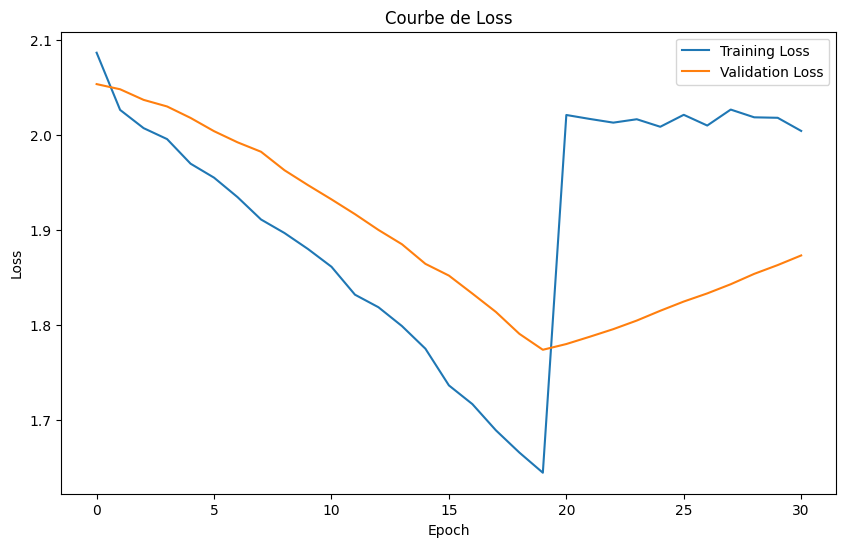

In [ ]:
import matplotlib.pyplot as plt

# Combinaison des courbes de perte des deux phases
train_loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


# RESNET


In [ ]:
import os
import numpy as np
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# =========================
# 1) Paramètres & Générateurs
# =========================
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32

# Supposons que train_generator et val_generator soient déjà définis
# et qu'ils appliquent un prétraitement compatible ResNet (par ex. tf.keras.applications.resnet50.preprocess_input).
# Sinon, assurez-vous de l'ajouter dans votre code de génération.

# =========================
# 2) Construction du modèle
# =========================
# Charger ResNet50 pré-entraîné sur ImageNet, sans la tête fully-connected
base_model = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Phase 1 : geler toutes les couches du ResNet
for layer in base_model.layers:
    layer.trainable = False

# Construction de la tête de classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # Dropout modéré
x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-5)
)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# =========================
# 3) Phase 1 : Entraîner la tête
# =========================
# On choisit un LR plutôt modéré (ex: 1e-4)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase1 = ModelCheckpoint(
    "best_phase1.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Ajustez selon la taille de votre dataset
    callbacks=[checkpoint_phase1, early_stop, reduce_lr]
)

# Recharger les meilleurs poids de la Phase 1
model.load_weights("best_phase1.h5")

# =========================
# 4) Phase 2 : Fine-tuning
# =========================
# Débloquer, par exemple, les 50 dernières couches du ResNet50
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Recompiler avec un LR plus faible pour affiner les couches dégélées
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase2 = ModelCheckpoint(
    "best_phase2.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stop_2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,  # Ajustez selon vos besoins
    callbacks=[checkpoint_phase2, early_stop_2, reduce_lr_2]
)

# Recharger le meilleur modèle obtenu en Phase 2 (optionnel)
model.load_weights("best_phase2.h5")

# =========================
# 5) Évaluation finale
# =========================
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2366 - loss: 2.5728
Epoch 1: val_loss improved from inf to 1.77057, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 656ms/step - accuracy: 0.2374 - loss: 2.5684 - val_accuracy: 0.3789 - val_loss: 1.7706 - learning_rate: 1.0000e-04
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3473 - loss: 1.9638
Epoch 2: val_loss improved from 1.77057 to 1.58451, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.3472 - loss: 1.9631 - val_accuracy: 0.4336 - val_loss: 1.5845 - learning_rate: 1.0000e-04
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.3820 - loss: 1.7519
Epoch 3: val_loss improved from 1.58451 to 1.48015, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.3824 - loss: 1.7514 - val_accuracy: 0.4922 - val_loss: 1.4801 - learning_rate: 1.0000e-04
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4170 - loss: 1.6117
Epoch 4: val_loss improved from 1.48015 to 1.38496, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.4178 - loss: 1.6100 - val_accuracy: 0.5156 - val_loss: 1.3850 - learning_rate: 1.0000e-04
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.4938 - loss: 1.4474
Epoch 5: val_loss improved from 1.38496 to 1.30443, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.4938 - loss: 1.4472 - val_accuracy: 0.5352 - val_loss: 1.3044 - learning_rate: 1.0000e-04
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5095 - loss: 1.3866
Epoch 6: val_loss improved from 1.30443 to 1.24007, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy: 0.5099 - loss: 1.3860 - val_accuracy: 0.5547 - val_loss: 1.2401 - learning_rate: 1.0000e-04
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5399 - loss: 1.3173
Epoch 7: val_loss improved from 1.24007 to 1.18988, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 520ms/step - accuracy: 0.5398 - loss: 1.3172 - val_accuracy: 0.5664 - val_loss: 1.1899 - learning_rate: 1.0000e-04
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5382 - loss: 1.3189
Epoch 8: val_loss improved from 1.18988 to 1.14665, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.5386 - loss: 1.3176 - val_accuracy: 0.5742 - val_loss: 1.1467 - learning_rate: 1.0000e-04
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.5944 - loss: 1.2355
Epoch 9: val_loss improved from 1.14665 to 1.12683, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.5946 - loss: 1.2342 - val_accuracy: 0.5977 - val_loss: 1.1268 - learning_rate: 1.0000e-04
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6088 - loss: 1.1492
Epoch 10: val_loss improved from 1.12683 to 1.09418, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.6088 - loss: 1.1488 - val_accuracy: 0.6055 - val_loss: 1.0942 - learning_rate: 1.0000e-04
Epoch 11/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5890 - loss: 1.0933
Epoch 11: val_loss improved from 1.09418 to 1.03490, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 504ms/step - accuracy: 0.5896 - loss: 1.0925 - val_accuracy: 0.6055 - val_loss: 1.0349 - learning_rate: 1.0000e-04
Epoch 12/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6364 - loss: 1.0525
Epoch 12: val_loss improved from 1.03490 to 1.02712, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.6360 - loss: 1.0524 - val_accuracy: 0.6172 - val_loss: 1.0271 - learning_rate: 1.0000e-04
Epoch 13/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6539 - loss: 0.9754
Epoch 13: val_loss improved from 1.02712 to 1.01495, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.6535 - loss: 0.9764 - val_accuracy: 0.6250 - val_loss: 1.0150 - learning_rate: 1.0000e-04
Epoch 14/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.6561 - loss: 0.9839
Epoch 14: val_loss improved from 1.01495 to 0.97505, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.6560 - loss: 0.9841 - val_accuracy: 0.6406 - val_loss: 0.9751 - learning_rate: 1.0000e-04
Epoch 15/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6610 - loss: 0.9292
Epoch 15: val_loss improved from 0.97505 to 0.95110, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.6609 - loss: 0.9298 - val_accuracy: 0.6484 - val_loss: 0.9511 - learning_rate: 1.0000e-04
Epoch 1/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6478 - loss: 0.9879
Epoch 1: val_loss improved from inf to 0.96229, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.6479 - loss: 0.9874 - val_accuracy: 0.6328 - val_loss: 0.9623 - learning_rate: 1.0000e-05
Epoch 2/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6495 - loss: 0.9659
Epoch 2: val_loss did not improve from 0.96229
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 494ms/step - accuracy: 0.6498 - loss: 0.9644 - val_accuracy: 0.6328 - val_loss: 0.9653 - learning_rate: 1.0000e-05
Epoch 3/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7077 - loss: 0.8910
Epoch 3: val_loss improved from 0.96229 to 0.95529, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - accuracy: 0.7079 - loss: 0.8906 - val_accuracy: 0.6484 - val_loss: 0.9553 - learning_rate: 1.0000e-05
Epoch 4/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7103 - loss: 0.8598
Epoch 4: val_loss improved from 0.95529 to 0.94642, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 533ms/step - accuracy: 0.7098 - loss: 0.8603 - val_accuracy: 0.6445 - val_loss: 0.9464 - learning_rate: 1.0000e-05
Epoch 5/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7184 - loss: 0.7950
Epoch 5: val_loss improved from 0.94642 to 0.93837, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.7180 - loss: 0.7963 - val_accuracy: 0.6484 - val_loss: 0.9384 - learning_rate: 1.0000e-05
Epoch 6/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7056 - loss: 0.8257
Epoch 6: val_loss improved from 0.93837 to 0.92916, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - accuracy: 0.7055 - loss: 0.8260 - val_accuracy: 0.6562 - val_loss: 0.9292 - learning_rate: 1.0000e-05
Epoch 7/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7519 - loss: 0.7946
Epoch 7: val_loss improved from 0.92916 to 0.91415, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.7516 - loss: 0.7946 - val_accuracy: 0.6562 - val_loss: 0.9141 - learning_rate: 1.0000e-05
Epoch 8/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7445 - loss: 0.7603
Epoch 8: val_loss improved from 0.91415 to 0.91338, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 522ms/step - accuracy: 0.7441 - loss: 0.7613 - val_accuracy: 0.6484 - val_loss: 0.9134 - learning_rate: 1.0000e-05
Epoch 9/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7187 - loss: 0.7929
Epoch 9: val_loss improved from 0.91338 to 0.90258, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - accuracy: 0.7188 - loss: 0.7930 - val_accuracy: 0.6602 - val_loss: 0.9026 - learning_rate: 1.0000e-05
Epoch 10/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7549 - loss: 0.7071
Epoch 10: val_loss improved from 0.90258 to 0.89772, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.7542 - loss: 0.7083 - val_accuracy: 0.6641 - val_loss: 0.8977 - learning_rate: 1.0000e-05
Epoch 11/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7415 - loss: 0.7512
Epoch 11: val_loss improved from 0.89772 to 0.89192, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.7413 - loss: 0.7510 - val_accuracy: 0.6602 - val_loss: 0.8919 - learning_rate: 1.0000e-05
Epoch 12/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7405 - loss: 0.7385
Epoch 12: val_loss improved from 0.89192 to 0.88294, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.7412 - loss: 0.7375 - val_accuracy: 0.6641 - val_loss: 0.8829 - learning_rate: 1.0000e-05
Epoch 13/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7691 - loss: 0.6919
Epoch 13: val_loss improved from 0.88294 to 0.87189, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.7688 - loss: 0.6923 - val_accuracy: 0.6602 - val_loss: 0.8719 - learning_rate: 1.0000e-05
Epoch 14/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7536 - loss: 0.6785
Epoch 14: val_loss improved from 0.87189 to 0.86376, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 533ms/step - accuracy: 0.7538 - loss: 0.6782 - val_accuracy: 0.6562 - val_loss: 0.8638 - learning_rate: 1.0000e-05
Epoch 15/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7626 - loss: 0.6774
Epoch 15: val_loss improved from 0.86376 to 0.86307, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.7627 - loss: 0.6773 - val_accuracy: 0.6602 - val_loss: 0.8631 - learning_rate: 1.0000e-05
Epoch 16/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7859 - loss: 0.6843
Epoch 16: val_loss did not improve from 0.86307
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.7860 - loss: 0.6836 - val_accuracy: 0.6641 - val_loss: 0.8640 - learning_rate: 1.0000e-05
Epoch 17/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7759 - loss: 0.6293
Epoch 17: val_loss improved from 0.86307 to 0.85293, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - accuracy: 0.7759 - loss: 0.6297 - val_accuracy: 0.6641 - val_loss: 0.8529 - learning_rate: 1.0000e-05
Epoch 18/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7932 - loss: 0.5847
Epoch 18: val_loss improved from 0.85293 to 0.84641, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.7929 - loss: 0.5854 - val_accuracy: 0.6484 - val_loss: 0.8464 - learning_rate: 1.0000e-05
Epoch 19/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7803 - loss: 0.6078
Epoch 19: val_loss improved from 0.84641 to 0.83694, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 537ms/step - accuracy: 0.7803 - loss: 0.6076 - val_accuracy: 0.6641 - val_loss: 0.8369 - learning_rate: 1.0000e-05
Epoch 20/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8154 - loss: 0.5919
Epoch 20: val_loss improved from 0.83694 to 0.82891, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 494ms/step - accuracy: 0.8149 - loss: 0.5919 - val_accuracy: 0.6719 - val_loss: 0.8289 - learning_rate: 1.0000e-05
Epoch 21/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7924 - loss: 0.6285
Epoch 21: val_loss improved from 0.82891 to 0.82706, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - accuracy: 0.7927 - loss: 0.6276 - val_accuracy: 0.6797 - val_loss: 0.8271 - learning_rate: 1.0000e-05
Epoch 22/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8274 - loss: 0.5275
Epoch 22: val_loss improved from 0.82706 to 0.82056, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 534ms/step - accuracy: 0.8271 - loss: 0.5279 - val_accuracy: 0.6875 - val_loss: 0.8206 - learning_rate: 1.0000e-05
Epoch 23/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8330 - loss: 0.5123
Epoch 23: val_loss did not improve from 0.82056
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.8327 - loss: 0.5130 - val_accuracy: 0.6992 - val_loss: 0.8230 - learning_rate: 1.0000e-05
Epoch 24/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7757 - loss: 0.6050
Epoch 24: val_loss improved from 0.82056 to 0.81090, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.7761 - loss: 0.6041 - val_accuracy: 0.6875 - val_loss: 0.8109 - learning_rate: 1.0000e-05
Epoch 25/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8456 - loss: 0.5128
Epoch 25: val_loss did not improve from 0.81090
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 480ms/step - accuracy: 0.8452 - loss: 0.5132 - val_accuracy: 0.6914 - val_loss: 0.8128 - learning_rate: 1.0000e-05
Epoch 26/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8096 - loss: 0.5438
Epoch 26: val_loss did not improve from 0.81090

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.8098 - loss: 0.5433 - val_accuracy: 0.6836 - val_loss: 0.8179 - learning_rate: 1.0000e-05
Epoch 27/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8426 - loss: 0.5018
Epoch 27: val_loss did not improve from 0.81090
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - accuracy: 0.8425 - loss: 0.5017 - v

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.6624 - loss: 0.8357
Validation accuracy finale : 0.6875


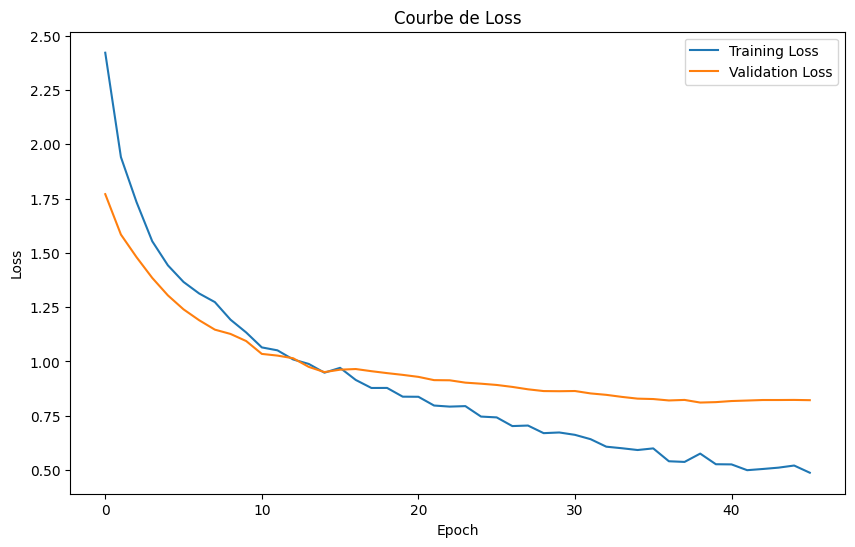

In [ ]:
import matplotlib.pyplot as plt

# Combinaison des courbes de perte des deux phases
train_loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


# resnet50 score 0,38


In [ ]:
import os
import numpy as np
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# =========================
# 1) Paramètres & Générateurs
# =========================
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32

# Supposons que train_generator et val_generator soient déjà définis
# et qu'ils appliquent un prétraitement compatible ResNet (par ex. tf.keras.applications.resnet50.preprocess_input).
# Sinon, assurez-vous de l'ajouter dans votre code de génération.

# =========================
# 2) Construction du modèle
# =========================
# Charger ResNet50 pré-entraîné sur ImageNet, sans la tête fully-connected
base_model = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Phase 1 : geler toutes les couches du ResNet
for layer in base_model.layers:
    layer.trainable = False

# Construction de la tête de classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # Dropout modéré
x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=regularizers.l2(1e-5)
)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# =========================
# 3) Phase 1 : Entraîner la tête
# =========================
# On choisit un LR plutôt modéré (ex: 1e-4)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase1 = ModelCheckpoint(
    "best_phase1.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Ajustez selon la taille de votre dataset
    callbacks=[checkpoint_phase1, early_stop, reduce_lr]
)

# Recharger les meilleurs poids de la Phase 1
model.load_weights("best_phase1.h5")

# =========================
# 4) Phase 2 : Fine-tuning
# =========================
# Débloquer, par exemple, les 50 dernières couches du ResNet50
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompiler avec un LR plus faible pour affiner les couches dégélées
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase2 = ModelCheckpoint(
    "best_phase2.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stop_2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,  # Ajustez selon vos besoins
    callbacks=[checkpoint_phase2, early_stop_2, reduce_lr_2]
)

# Recharger le meilleur modèle obtenu en Phase 2 (optionnel)
model.load_weights("best_phase2.h5")

# =========================
# 5) Évaluation finale
# =========================
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1456 - loss: 2.9544
Epoch 1: val_loss improved from inf to 1.89041, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 623ms/step - accuracy: 0.1474 - loss: 2.9444 - val_accuracy: 0.3867 - val_loss: 1.8904 - learning_rate: 1.0000e-04
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2929 - loss: 2.0944
Epoch 2: val_loss improved from 1.89041 to 1.64620, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - accuracy: 0.2935 - loss: 2.0920 - val_accuracy: 0.4609 - val_loss: 1.6462 - learning_rate: 1.0000e-04
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4048 - loss: 1.7692
Epoch 3: val_loss improved from 1.64620 to 1.49841, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.4048 - loss: 1.7692 - val_accuracy: 0.5352 - val_loss: 1.4984 - learning_rate: 1.0000e-04
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4286 - loss: 1.6183
Epoch 4: val_loss improved from 1.49841 to 1.39368, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 486ms/step - accuracy: 0.4293 - loss: 1.6182 - val_accuracy: 0.5312 - val_loss: 1.3937 - learning_rate: 1.0000e-04
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.4827 - loss: 1.5354
Epoch 5: val_loss improved from 1.39368 to 1.31245, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step - accuracy: 0.4827 - loss: 1.5344 - val_accuracy: 0.5664 - val_loss: 1.3124 - learning_rate: 1.0000e-04
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.5202 - loss: 1.3558
Epoch 6: val_loss improved from 1.31245 to 1.24853, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5203 - loss: 1.3558 - val_accuracy: 0.5703 - val_loss: 1.2485 - learning_rate: 1.0000e-04
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5430 - loss: 1.3277
Epoch 7: val_loss improved from 1.24853 to 1.18308, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.5428 - loss: 1.3274 - val_accuracy: 0.5820 - val_loss: 1.1831 - learning_rate: 1.0000e-04
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5252 - loss: 1.3096
Epoch 8: val_loss improved from 1.18308 to 1.13456, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.5263 - loss: 1.3074 - val_accuracy: 0.5781 - val_loss: 1.1346 - learning_rate: 1.0000e-04
Epoch 9/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5524 - loss: 1.2377
Epoch 9: val_loss improved from 1.13456 to 1.09655, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - accuracy: 0.5530 - loss: 1.2369 - val_accuracy: 0.5820 - val_loss: 1.0966 - learning_rate: 1.0000e-04
Epoch 10/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5837 - loss: 1.1315
Epoch 10: val_loss improved from 1.09655 to 1.06614, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - accuracy: 0.5839 - loss: 1.1323 - val_accuracy: 0.6133 - val_loss: 1.0661 - learning_rate: 1.0000e-04
Epoch 11/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6136 - loss: 1.1101
Epoch 11: val_loss improved from 1.06614 to 1.02102, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - accuracy: 0.6133 - loss: 1.1107 - val_accuracy: 0.6211 - val_loss: 1.0210 - learning_rate: 1.0000e-04
Epoch 12/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6315 - loss: 1.0702
Epoch 12: val_loss improved from 1.02102 to 1.01771, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.6315 - loss: 1.0702 - val_accuracy: 0.6445 - val_loss: 1.0177 - learning_rate: 1.0000e-04
Epoch 13/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6496 - loss: 1.0180
Epoch 13: val_loss improved from 1.01771 to 0.99330, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - accuracy: 0.6495 - loss: 1.0175 - val_accuracy: 0.6797 - val_loss: 0.9933 - learning_rate: 1.0000e-04
Epoch 14/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6361 - loss: 0.9966
Epoch 14: val_loss improved from 0.99330 to 0.98955, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - accuracy: 0.6358 - loss: 0.9976 - val_accuracy: 0.6758 - val_loss: 0.9896 - learning_rate: 1.0000e-04
Epoch 15/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6271 - loss: 1.0571
Epoch 15: val_loss improved from 0.98955 to 0.95325, saving model to best_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - accuracy: 0.6278 - loss: 1.0554 - val_accuracy: 0.6836 - val_loss: 0.9533 - learning_rate: 1.0000e-04
Epoch 1/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5737 - loss: 1.2483
Epoch 1: val_loss improved from inf to 0.95570, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 693ms/step - accuracy: 0.5740 - loss: 1.2462 - val_accuracy: 0.6836 - val_loss: 0.9557 - learning_rate: 1.0000e-05
Epoch 2/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6530 - loss: 0.9925
Epoch 2: val_loss improved from 0.95570 to 0.95354, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 559ms/step - accuracy: 0.6534 - loss: 0.9914 - val_accuracy: 0.6562 - val_loss: 0.9535 - learning_rate: 1.0000e-05
Epoch 3/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7146 - loss: 0.8436
Epoch 3: val_loss improved from 0.95354 to 0.93270, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 566ms/step - accuracy: 0.7146 - loss: 0.8434 - val_accuracy: 0.6562 - val_loss: 0.9327 - learning_rate: 1.0000e-05
Epoch 4/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7679 - loss: 0.7439
Epoch 4: val_loss improved from 0.93270 to 0.89679, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.7673 - loss: 0.7441 - val_accuracy: 0.6602 - val_loss: 0.8968 - learning_rate: 1.0000e-05
Epoch 5/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7736 - loss: 0.6657
Epoch 5: val_loss improved from 0.89679 to 0.85122, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 557ms/step - accuracy: 0.7734 - loss: 0.6660 - val_accuracy: 0.6797 - val_loss: 0.8512 - learning_rate: 1.0000e-05
Epoch 6/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7907 - loss: 0.6317
Epoch 6: val_loss improved from 0.85122 to 0.81221, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 553ms/step - accuracy: 0.7907 - loss: 0.6315 - val_accuracy: 0.7109 - val_loss: 0.8122 - learning_rate: 1.0000e-05
Epoch 7/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7990 - loss: 0.5967
Epoch 7: val_loss improved from 0.81221 to 0.78148, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - accuracy: 0.7991 - loss: 0.5967 - val_accuracy: 0.7227 - val_loss: 0.7815 - learning_rate: 1.0000e-05
Epoch 8/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8353 - loss: 0.5082
Epoch 8: val_loss improved from 0.78148 to 0.76610, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.8354 - loss: 0.5080 - val_accuracy: 0.7344 - val_loss: 0.7661 - learning_rate: 1.0000e-05
Epoch 9/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8655 - loss: 0.4759
Epoch 9: val_loss improved from 0.76610 to 0.74176, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - accuracy: 0.8656 - loss: 0.4753 - val_accuracy: 0.7344 - val_loss: 0.7418 - learning_rate: 1.0000e-05
Epoch 10/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8521 - loss: 0.4701
Epoch 10: val_loss improved from 0.74176 to 0.73353, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step - accuracy: 0.8522 - loss: 0.4695 - val_accuracy: 0.7383 - val_loss: 0.7335 - learning_rate: 1.0000e-05
Epoch 11/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8858 - loss: 0.3797
Epoch 11: val_loss improved from 0.73353 to 0.72071, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 558ms/step - accuracy: 0.8860 - loss: 0.3797 - val_accuracy: 0.7461 - val_loss: 0.7207 - learning_rate: 1.0000e-05
Epoch 12/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9019 - loss: 0.3599
Epoch 12: val_loss improved from 0.72071 to 0.71140, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 539ms/step - accuracy: 0.9017 - loss: 0.3597 - val_accuracy: 0.7500 - val_loss: 0.7114 - learning_rate: 1.0000e-05
Epoch 13/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8899 - loss: 0.3605
Epoch 13: val_loss improved from 0.71140 to 0.69760, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step - accuracy: 0.8903 - loss: 0.3596 - val_accuracy: 0.7539 - val_loss: 0.6976 - learning_rate: 1.0000e-05
Epoch 14/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9387 - loss: 0.2708
Epoch 14: val_loss did not improve from 0.69760
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 526ms/step - accuracy: 0.9385 - loss: 0.2707 - val_accuracy: 0.7578 - val_loss: 0.7006 - learning_rate: 1.0000e-05
Epoch 15/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9368 - loss: 0.2570
Epoch 15: val_loss improved from 0.69760 to 0.68347, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 559ms/step - accuracy: 0.9366 - loss: 0.2570 - val_accuracy: 0.7617 - val_loss: 0.6835 - learning_rate: 1.0000e-05
Epoch 16/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9297 - loss: 0.2433
Epoch 16: val_loss improved from 0.68347 to 0.67871, saving model to best_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.9300 - loss: 0.2431 - val_accuracy: 0.7578 - val_loss: 0.6787 - learning_rate: 1.0000e-05
Epoch 17/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9544 - loss: 0.2152
Epoch 17: val_loss did not improve from 0.67871
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 534ms/step - accuracy: 0.9543 - loss: 0.2155 - val_accuracy: 0.7539 - val_loss: 0.6906 - learning_rate: 1.0000e-05
Epoch 18/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9545 - loss: 0.1826
Epoch 18: val_loss did not improve from 0.67871

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.9547 - loss: 0.1827 - val_accuracy: 0.7578 - val_loss: 0.6929 - learning_rate: 1.0000e-05
Epoch 19/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9545 - loss: 0.1805
Epoch 19: val_loss did not improve from 0.67871
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.9545 - loss: 0.1807 - v

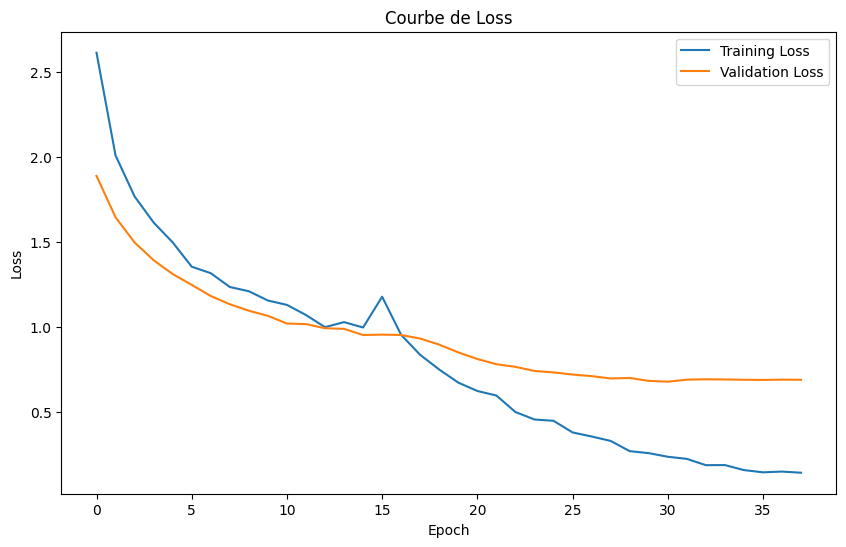

In [ ]:
import matplotlib.pyplot as plt

# Combinaison des courbes de perte des deux phases
train_loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.show()


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ========= 1. Préparation des images de test =========
# Chemin du dossier original contenant vos images de test (sans label dans le nom)
test_dir = '/content/drive/MyDrive/datatest'

# Chemin vers un dossier temporaire où l'on va copier les images en y ajoutant un label factice
temp_test_dir = '/content/drive/MyDrive/temp_test'
if not os.path.exists(temp_test_dir):
    os.makedirs(temp_test_dir)

# Lister les fichiers de test (par exemple, ceux se terminant par .jpg)
original_test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])

# Créer une nouvelle liste de noms en y ajoutant un label factice (ici "0")
# Exemple : "image1.jpg" -> "image1-0_.jpg"
renamed_test_filenames = []
for filename in original_test_filenames:
    base = os.path.splitext(filename)[0]
    new_filename = f"{base}-0_.jpg"  # label factice : 0
    renamed_test_filenames.append(new_filename)
    # Copier le fichier dans le dossier temporaire avec le nouveau nom
    shutil.copy(os.path.join(test_dir, filename), os.path.join(temp_test_dir, new_filename))

# ========= 2. Créer le générateur de test en utilisant votre classe existante =========
# On utilise votre générateur sans le modifier
test_generator = ImageLabelGenerator(
    image_dir=temp_test_dir,
    image_filenames=renamed_test_filenames,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False
)

# ========= 3. Prédire avec votre modèle =========
# La fonction model.predict utilisera le générateur.
preds_proba = model.predict(test_generator, steps=int(np.ceil(len(renamed_test_filenames) / 32)))
preds_classes = np.argmax(preds_proba, axis=1)

# ========= 4. Convertir les indices en labels lisibles =========
# Comme votre générateur ne possède pas .class_indices, on définit le mapping manuellement.
# Ici, on suppose que vos labels sont des entiers allant de 0 à NUM_CLASSES-1.
NUM_CLASSES = 9
inv_class_indices = {i: str(i) for i in range(NUM_CLASSES)}
predicted_labels = [inv_class_indices[idx] for idx in preds_classes]

# ========= 5. Créer et sauvegarder le fichier CSV de soumission =========
# On utilise les noms originaux (sans label factice) pour l'indexation
submission_df = pd.DataFrame({
    'idx': [os.path.splitext(f)[0] for f in original_test_filenames],
    'gt': predicted_labels
})

submission_csv_path = '/content/drive/MyDrive/resnet50.csv'
submission_df.to_csv(submission_csv_path, index=False)

print("Prédictions sur la base incertaine :")
print(submission_df.head())


42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step
Prédictions sur la base incertaine :
                                                 idx gt
0  0.000287271854623405430.157444760850390830.996...  0
1  0.0010863036917236890.47680670826091410.132699...  1
2  0.00353289859414340770.76539580712550110.01220...  0
3  0.0042943058174115260.7384949814241050.9756010...  8
4  0.0046691375801363180.53378260284225820.730659...  8


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Paramètres du modèle
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32

# ========================================================================
# Phase 1 : Construction du modèle et entraînement de la tête de classification
# ========================================================================

# Charger ResNet50 pré-entraîné sur ImageNet (sans la couche fully-connected)
base_model = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Geler toutes les couches du base_model
for layer in base_model.layers:
    layer.trainable = False

# Ajout d'une tête de classification plus profonde
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# Première couche dense pour enrichir la représentation (512 neurones)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
# Deuxième couche dense (256 neurones)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
# Couche de sortie
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# Compilation de la phase 1 avec un learning rate modéré
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour la phase 1
checkpoint_phase1 = ModelCheckpoint("best_resnet_phase1.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement de la phase 1 (seulement la tête)
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_phase1, early_stop, reduce_lr]
)

# Recharger les meilleurs poids obtenus en phase 1
model.load_weights("best_resnet_phase1.h5")

# ========================================================================
# Phase 2 : Fine-tuning du base_model (débloquer les 80 dernières couches)
# ========================================================================

# Débloquer les 80 dernières couches de ResNet50 pour affiner le modèle
for layer in base_model.layers[-80:]:
    layer.trainable = True

# Recompiler avec un learning rate très bas pour le fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour la phase 2
checkpoint_phase2 = ModelCheckpoint("best_resnet_phase2.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement de la phase 2 (fine-tuning)
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[checkpoint_phase2, early_stop_2, reduce_lr_2]
)

# Recharger les meilleurs poids obtenus en phase 2 (optionnel)
model.load_weights("best_resnet_phase2.h5")

# ========================================================================
# Évaluation finale du modèle
# ========================================================================
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.2274 - loss: 2.5394
Epoch 1: val_loss improved from inf to 1.76785, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 647ms/step - accuracy: 0.2291 - loss: 2.5308 - val_accuracy: 0.4648 - val_loss: 1.7679 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4014 - loss: 1.7882
Epoch 2: val_loss improved from 1.76785 to 1.49082, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 531ms/step - accuracy: 0.4022 - loss: 1.7862 - val_accuracy: 0.5391 - val_loss: 1.4908 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5205 - loss: 1.4828
Epoch 3: val_loss improved from 1.49082 to 1.31596, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.5208 - loss: 1.4816 - val_accuracy: 0.5742 - val_loss: 1.3160 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5868 - loss: 1.3181
Epoch 4: val_loss improved from 1.31596 to 1.25297, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.5869 - loss: 1.3172 - val_accuracy: 0.5742 - val_loss: 1.2530 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6682 - loss: 1.1267
Epoch 5: val_loss improved from 1.25297 to 1.15826, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.6674 - loss: 1.1276 - val_accuracy: 0.6289 - val_loss: 1.1583 - learning_rate: 1.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6601 - loss: 1.0795
Epoch 6: val_loss improved from 1.15826 to 1.09220, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step - accuracy: 0.6602 - loss: 1.0793 - val_accuracy: 0.6484 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7262 - loss: 0.9296
Epoch 7: val_loss improved from 1.09220 to 1.05309, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.7252 - loss: 0.9307 - val_accuracy: 0.6797 - val_loss: 1.0531 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7220 - loss: 0.9212
Epoch 8: val_loss improved from 1.05309 to 1.00291, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.7219 - loss: 0.9212 - val_accuracy: 0.6875 - val_loss: 1.0029 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7539 - loss: 0.8399
Epoch 9: val_loss improved from 1.00291 to 0.99866, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - accuracy: 0.7535 - loss: 0.8404 - val_accuracy: 0.6680 - val_loss: 0.9987 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7871 - loss: 0.7744
Epoch 10: val_loss improved from 0.99866 to 0.99772, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 494ms/step - accuracy: 0.7865 - loss: 0.7752 - val_accuracy: 0.6406 - val_loss: 0.9977 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7854 - loss: 0.7617
Epoch 11: val_loss improved from 0.99772 to 0.97861, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step - accuracy: 0.7849 - loss: 0.7620 - val_accuracy: 0.6914 - val_loss: 0.9786 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7959 - loss: 0.7179
Epoch 12: val_loss improved from 0.97861 to 0.93312, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.7960 - loss: 0.7172 - val_accuracy: 0.6836 - val_loss: 0.9331 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7965 - loss: 0.7130
Epoch 13: val_loss did not improve from 0.93312
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - accuracy: 0.7966 - loss: 0.7127 - val_accuracy: 0.7031 - val_loss: 0.9337 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8058 - loss: 0.6749
Epoch 14: val_loss improved from 0.93312 to 0.91004, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - accuracy: 0.8063 - loss: 0.6736 - val_accuracy: 0.7070 - val_loss: 0.9100 - learning_rate: 1.0000e-04
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8309 - loss: 0.5994
Epoch 15: val_loss improved from 0.91004 to 0.89627, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.8306 - loss: 0.6000 - val_accuracy: 0.7148 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8523 - loss: 0.5395
Epoch 16: val_loss improved from 0.89627 to 0.87654, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step - accuracy: 0.8519 - loss: 0.5405 - val_accuracy: 0.7227 - val_loss: 0.8765 - learning_rate: 1.0000e-04
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8461 - loss: 0.5537
Epoch 17: val_loss did not improve from 0.87654
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - accuracy: 0.8462 - loss: 0.5536 - val_accuracy: 0.7070 - val_loss: 0.8994 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8567 - loss: 0.5229
Epoch 18: val_loss improved from 0.87654 to 0.86854, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.8569 - loss: 0.5223 - val_accuracy: 0.7266 - val_loss: 0.8685 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8637 - loss: 0.4948
Epoch 19: val_loss did not improve from 0.86854
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - accuracy: 0.8638 - loss: 0.4950 - val_accuracy: 0.7227 - val_loss: 0.8752 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8861 - loss: 0.4644
Epoch 20: val_loss improved from 0.86854 to 0.84572, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.8860 - loss: 0.4644 - val_accuracy: 0.7422 - val_loss: 0.8457 - learning_rate: 1.0000e-04
Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6767 - loss: 1.0023
Epoch 1: val_loss improved from inf to 0.97477, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 735ms/step - accuracy: 0.6776 - loss: 1.0006 - val_accuracy: 0.7266 - val_loss: 0.9748 - learning_rate: 1.0000e-05
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8078 - loss: 0.6925
Epoch 2: val_loss improved from 0.97477 to 0.93827, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 693ms/step - accuracy: 0.8079 - loss: 0.6927 - val_accuracy: 0.7383 - val_loss: 0.9383 - learning_rate: 1.0000e-05
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8269 - loss: 0.6184
Epoch 3: val_loss improved from 0.93827 to 0.92201, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.8271 - loss: 0.6179 - val_accuracy: 0.7383 - val_loss: 0.9220 - learning_rate: 1.0000e-05
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8644 - loss: 0.5261
Epoch 4: val_loss improved from 0.92201 to 0.88198, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.8645 - loss: 0.5261 - val_accuracy: 0.7500 - val_loss: 0.8820 - learning_rate: 1.0000e-05
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9126 - loss: 0.4415
Epoch 5: val_loss improved from 0.88198 to 0.86204, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - accuracy: 0.9123 - loss: 0.4414 - val_accuracy: 0.7422 - val_loss: 0.8620 - learning_rate: 1.0000e-05
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9255 - loss: 0.3911
Epoch 6: val_loss improved from 0.86204 to 0.83139, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 611ms/step - accuracy: 0.9256 - loss: 0.3909 - val_accuracy: 0.7578 - val_loss: 0.8314 - learning_rate: 1.0000e-05
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9384 - loss: 0.3385
Epoch 7: val_loss improved from 0.83139 to 0.82054, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 612ms/step - accuracy: 0.9382 - loss: 0.3389 - val_accuracy: 0.7656 - val_loss: 0.8205 - learning_rate: 1.0000e-05
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9407 - loss: 0.3358
Epoch 8: val_loss did not improve from 0.82054
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 558ms/step - accuracy: 0.9407 - loss: 0.3358 - val_accuracy: 0.7578 - val_loss: 0.8351 - learning_rate: 1.0000e-05
Epoch 9/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9623 - loss: 0.2874
Epoch 9: val_loss did not improve from 0.82054
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.9620 - loss: 0.2877 - val_accuracy: 0.7500 - val_loss: 0.8263 - learning_rate: 1.0000e-05
Epoch 10/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9716 - loss: 0.2675
Epoch 10: val_loss did not improve from 0.82054

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - accuracy: 0.9718 - loss: 0.2674 - val_a

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Paramètres
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 9
BATCH_SIZE = 32

# Supposons que train_generator et val_generator soient déjà définis,
# avec le prétraitement compatible avec ResNet50 (ex: tf.keras.applications.resnet50.preprocess_input)
# et une data augmentation adéquate.

# ====================================================================
# Phase 1 : Construction du modèle et entraînement de la tête
# ====================================================================

# Charger le modèle ResNet50 pré-entraîné (sans le fully-connected top)
base_model = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Geler le base_model
for layer in base_model.layers:
    layer.trainable = False

# Extraction des caractéristiques via hybrid pooling (Average + Max)
x_avg = layers.GlobalAveragePooling2D()(base_model.output)
x_max = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Concatenate()([x_avg, x_max])

# Tête de classification plus profonde
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# Compilation de la Phase 1 avec un LR modéré
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour Phase 1
checkpoint_phase1 = ModelCheckpoint("best_resnet_phase1.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement de la Phase 1 (tête seule)
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_phase1, early_stop, reduce_lr]
)

# Recharger les meilleurs poids de la Phase 1
model.load_weights("best_resnet_phase1.h5")

# ====================================================================
# Phase 2 : Fine-tuning
# ====================================================================

# Débloquer les 100 dernières couches du ResNet50 pour un fine-tuning plus poussé
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompiler avec un LR très bas
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour Phase 2
checkpoint_phase2 = ModelCheckpoint("best_resnet_phase2.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Entraînement de la Phase 2 (fine-tuning)
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[checkpoint_phase2, early_stop_2, reduce_lr_2]
)

# Recharger les meilleurs poids obtenus en Phase 2 (optionnel)
model.load_weights("best_resnet_phase2.h5")

# Évaluation finale
loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.2330 - loss: 5.6609
Epoch 1: val_loss improved from inf to 1.98989, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 643ms/step - accuracy: 0.2336 - loss: 5.6307 - val_accuracy: 0.4141 - val_loss: 1.9899 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3670 - loss: 2.4809
Epoch 2: val_loss improved from 1.98989 to 1.46780, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.3673 - loss: 2.4782 - val_accuracy: 0.5000 - val_loss: 1.4678 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4329 - loss: 1.9172
Epoch 3: val_loss did not improve from 1.46780
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 475ms/step - accuracy: 0.4334 - loss: 1.9159 - val_accuracy: 0.4883 - val_loss: 1.5932 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4917 - loss: 1.6568
Epoch 4: val_loss improved from 1.46780 to 1.37324, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.4923 - loss: 1.6553 - val_accuracy: 0.5273 - val_loss: 1.3732 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5545 - loss: 1.4790
Epoch 5: val_loss improved from 1.37324 to 1.31798, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - accuracy: 0.5547 - loss: 1.4791 - val_accuracy: 0.5625 - val_loss: 1.3180 - learning_rate: 1.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5882 - loss: 1.3457
Epoch 6: val_loss improved from 1.31798 to 1.28364, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 504ms/step - accuracy: 0.5887 - loss: 1.3450 - val_accuracy: 0.5938 - val_loss: 1.2836 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5996 - loss: 1.2252
Epoch 7: val_loss improved from 1.28364 to 1.26801, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 0.6000 - loss: 1.2258 - val_accuracy: 0.5703 - val_loss: 1.2680 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6676 - loss: 1.1550
Epoch 8: val_loss improved from 1.26801 to 1.22003, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 531ms/step - accuracy: 0.6673 - loss: 1.1541 - val_accuracy: 0.5703 - val_loss: 1.2200 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6601 - loss: 1.0737
Epoch 9: val_loss improved from 1.22003 to 1.21708, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.6601 - loss: 1.0740 - val_accuracy: 0.6094 - val_loss: 1.2171 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.6919 - loss: 0.9518
Epoch 10: val_loss improved from 1.21708 to 1.19596, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.6917 - loss: 0.9527 - val_accuracy: 0.6133 - val_loss: 1.1960 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7228 - loss: 0.8854
Epoch 11: val_loss improved from 1.19596 to 1.09936, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - accuracy: 0.7229 - loss: 0.8857 - val_accuracy: 0.6289 - val_loss: 1.0994 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7491 - loss: 0.8099
Epoch 12: val_loss did not improve from 1.09936
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.7490 - loss: 0.8104 - val_accuracy: 0.6445 - val_loss: 1.1377 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7599 - loss: 0.8153
Epoch 13: val_loss improved from 1.09936 to 1.07509, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.7596 - loss: 0.8159 - val_accuracy: 0.6445 - val_loss: 1.0751 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7874 - loss: 0.6784
Epoch 14: val_loss improved from 1.07509 to 1.06268, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 535ms/step - accuracy: 0.7877 - loss: 0.6788 - val_accuracy: 0.6719 - val_loss: 1.0627 - learning_rate: 1.0000e-04
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7705 - loss: 0.7724
Epoch 15: val_loss did not improve from 1.06268
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 473ms/step - accuracy: 0.7704 - loss: 0.7725 - val_accuracy: 0.6094 - val_loss: 1.1433 - learning_rate: 1.0000e-04
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7984 - loss: 0.6813
Epoch 16: val_loss improved from 1.06268 to 1.05271, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.7982 - loss: 0.6815 - val_accuracy: 0.6641 - val_loss: 1.0527 - learning_rate: 1.0000e-04
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8075 - loss: 0.6360
Epoch 17: val_loss did not improve from 1.05271
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.8076 - loss: 0.6357 - val_accuracy: 0.6797 - val_loss: 1.0587 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8206 - loss: 0.6219
Epoch 18: val_loss improved from 1.05271 to 1.03939, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.8209 - loss: 0.6209 - val_accuracy: 0.6758 - val_loss: 1.0394 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8276 - loss: 0.5968
Epoch 19: val_loss improved from 1.03939 to 1.02575, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.8281 - loss: 0.5961 - val_accuracy: 0.6875 - val_loss: 1.0258 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8740 - loss: 0.5189
Epoch 20: val_loss improved from 1.02575 to 1.00029, saving model to best_resnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 535ms/step - accuracy: 0.8734 - loss: 0.5195 - val_accuracy: 0.6914 - val_loss: 1.0003 - learning_rate: 1.0000e-04
Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5325 - loss: 1.8892
Epoch 1: val_loss improved from inf to 1.04551, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 770ms/step - accuracy: 0.5329 - loss: 1.8826 - val_accuracy: 0.6719 - val_loss: 1.0455 - learning_rate: 1.0000e-05
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6223 - loss: 1.1702
Epoch 2: val_loss did not improve from 1.04551
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 582ms/step - accuracy: 0.6231 - loss: 1.1699 - val_accuracy: 0.6641 - val_loss: 1.0770 - learning_rate: 1.0000e-05
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7105 - loss: 0.9333
Epoch 3: val_loss did not improve from 1.04551
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - accuracy: 0.7108 - loss: 0.9330 - val_accuracy: 0.6680 - val_loss: 1.0692 - learning_rate: 1.0000e-05
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7419 - loss: 0.8368
Epoch 4: val_loss improved from 1.04551 to 1.03595, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step - accuracy: 0.7416 - loss: 0.8375 - val_accuracy: 0.6992 - val_loss: 1.0360 - learning_rate: 1.0000e-05
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7778 - loss: 0.7487
Epoch 5: val_loss did not improve from 1.03595
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 554ms/step - accuracy: 0.7777 - loss: 0.7488 - val_accuracy: 0.6875 - val_loss: 1.0440 - learning_rate: 1.0000e-05
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7995 - loss: 0.6989
Epoch 6: val_loss improved from 1.03595 to 1.02821, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 693ms/step - accuracy: 0.7997 - loss: 0.6983 - val_accuracy: 0.7031 - val_loss: 1.0282 - learning_rate: 1.0000e-05
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8549 - loss: 0.5188
Epoch 7: val_loss improved from 1.02821 to 1.01807, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 749ms/step - accuracy: 0.8545 - loss: 0.5202 - val_accuracy: 0.7227 - val_loss: 1.0181 - learning_rate: 1.0000e-05
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8566 - loss: 0.5299
Epoch 8: val_loss did not improve from 1.01807
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.8564 - loss: 0.5303 - val_accuracy: 0.7070 - val_loss: 1.0365 - learning_rate: 1.0000e-05
Epoch 9/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8528 - loss: 0.5163
Epoch 9: val_loss improved from 1.01807 to 1.01774, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 660ms/step - accuracy: 0.8531 - loss: 0.5154 - val_accuracy: 0.7266 - val_loss: 1.0177 - learning_rate: 1.0000e-05
Epoch 10/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9048 - loss: 0.4105
Epoch 10: val_loss did not improve from 1.01774
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 582ms/step - accuracy: 0.9046 - loss: 0.4110 - val_accuracy: 0.7109 - val_loss: 1.0316 - learning_rate: 1.0000e-05
Epoch 11/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8794 - loss: 0.4409
Epoch 11: val_loss did not improve from 1.01774
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 582ms/step - accuracy: 0.8798 - loss: 0.4400 - val_accuracy: 0.7148 - val_loss: 1.0479 - learning_rate: 1.0000e-05
Epoch 12/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9327 - loss: 0.3317
Epoch 12: val_loss did not improve from 1.01774

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 583ms/step - accuracy: 0.9323 - loss: 0.3326 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 861ms/step - accuracy: 0.9259 - loss: 0.3339 - val_accuracy: 0.7227 - val_loss: 1.0169 - learning_rate: 5.0000e-06
Epoch 15/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9407 - loss: 0.3166
Epoch 15: val_loss did not improve from 1.01693
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 589ms/step - accuracy: 0.9407 - loss: 0.3168 - val_accuracy: 0.7188 - val_loss: 1.0176 - learning_rate: 5.0000e-06
Epoch 16/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9287 - loss: 0.3117
Epoch 16: val_loss improved from 1.01693 to 0.99776, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.9288 - loss: 0.3119 - val_accuracy: 0.7188 - val_loss: 0.9978 - learning_rate: 5.0000e-06
Epoch 17/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9547 - loss: 0.2926
Epoch 17: val_loss did not improve from 0.99776
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.9541 - loss: 0.2938 - val_accuracy: 0.7188 - val_loss: 1.0077 - learning_rate: 5.0000e-06
Epoch 18/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9409 - loss: 0.2917
Epoch 18: val_loss did not improve from 0.99776
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - accuracy: 0.9405 - loss: 0.2924 - val_accuracy: 0.7148 - val_loss: 1.0155 - learning_rate: 5.0000e-06
Epoch 19/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9431 - loss: 0.2855
Epoch 19: val_loss did not improve from 0.99776

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 588ms/step - accuracy: 0.9431 - loss: 0.2855 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 782ms/step - accuracy: 0.9472 - loss: 0.2854 - val_accuracy: 0.7188 - val_loss: 0.9955 - learning_rate: 2.5000e-06
Epoch 22/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9477 - loss: 0.2757
Epoch 22: val_loss improved from 0.99547 to 0.98968, saving model to best_resnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.9478 - loss: 0.2757 - val_accuracy: 0.7188 - val_loss: 0.9897 - learning_rate: 2.5000e-06
Epoch 23/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9285 - loss: 0.2942
Epoch 23: val_loss did not improve from 0.98968
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 610ms/step - accuracy: 0.9287 - loss: 0.2937 - val_accuracy: 0.7148 - val_loss: 0.9967 - learning_rate: 2.5000e-06
Epoch 24/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9300 - loss: 0.3078
Epoch 24: val_loss did not improve from 0.98968
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step - accuracy: 0.9304 - loss: 0.3073 - val_accuracy: 0.7188 - val_loss: 0.9982 - learning_rate: 2.5000e-06
Epoch 25/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9502 - loss: 0.2572
Epoch 25: val_loss did not improve from 0.98968

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 578ms/step - accuracy: 0.9502 - loss: 0.2574 - v

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Bloc Squeeze-and-Excitation ---
def squeeze_excite_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu',
                      kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid',
                      kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.multiply([input_tensor, se])
    return x

# --- Paramètres ---
IMG_HEIGHT = 300
IMG_WIDTH  = 300
NUM_CLASSES = 9
BATCH_SIZE = 32

# --- Phase 1 : Construction et entraînement de la tête ---
base_model = EfficientNetB3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Geler la base

# Construction de la nouvelle tête
x = base_model.output
x = squeeze_excite_block(x, ratio=16)
# Pooling hybride : Global Average Pooling + Global Max Pooling
gap = layers.GlobalAveragePooling2D()(x)
gmp = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([gap, gmp])
# Tête de classification approfondie
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase1 = ModelCheckpoint("best_efficientnet_phase1.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_phase1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_phase1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_phase1, early_stop_phase1, reduce_lr_phase1]
)

model.load_weights("best_efficientnet_phase1.h5")

# --- Phase 2 : Fine-tuning ---
for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase2 = ModelCheckpoint("best_efficientnet_phase2.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_phase2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[checkpoint_phase2, early_stop_phase2, reduce_lr_phase2]
)

model.load_weights("best_efficientnet_phase2.h5")

loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1811 - loss: 3.9683
Epoch 1: val_loss improved from inf to 1.91024, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.1822 - loss: 3.9475 - val_accuracy: 0.4453 - val_loss: 1.9102 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.2889 - loss: 2.2221
Epoch 2: val_loss improved from 1.91024 to 1.78635, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2889 - loss: 2.2230 - val_accuracy: 0.4570 - val_loss: 1.7864 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.3596 - loss: 1.9741
Epoch 3: val_loss improved from 1.78635 to 1.71305, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3596 - loss: 1.9746 - val_accuracy: 0.4414 - val_loss: 1.7130 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.3943 - loss: 1.8737
Epoch 4: val_loss improved from 1.71305 to 1.67832, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3942 - loss: 1.8742 - val_accuracy: 0.4766 - val_loss: 1.6783 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.4015 - loss: 1.8796
Epoch 5: val_loss improved from 1.67832 to 1.66179, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4023 - loss: 1.8773 - val_accuracy: 0.4648 - val_loss: 1.6618 - learning_rate: 1.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.4156 - loss: 1.7856
Epoch 6: val_loss improved from 1.66179 to 1.58193, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4161 - loss: 1.7847 - val_accuracy: 0.4883 - val_loss: 1.5819 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.4482 - loss: 1.7378
Epoch 7: val_loss improved from 1.58193 to 1.53554, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4483 - loss: 1.7371 - val_accuracy: 0.4961 - val_loss: 1.5355 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.4529 - loss: 1.6686
Epoch 8: val_loss improved from 1.53554 to 1.51757, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4530 - loss: 1.6680 - val_accuracy: 0.5312 - val_loss: 1.5176 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.4940 - loss: 1.5871
Epoch 9: val_loss improved from 1.51757 to 1.45095, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4939 - loss: 1.5865 - val_accuracy: 0.5312 - val_loss: 1.4510 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4831 - loss: 1.5880
Epoch 10: val_loss improved from 1.45095 to 1.42673, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4830 - loss: 1.5881 - val_accuracy: 0.5547 - val_loss: 1.4267 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.5106 - loss: 1.5170
Epoch 11: val_loss improved from 1.42673 to 1.39573, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5107 - loss: 1.5163 - val_accuracy: 0.5312 - val_loss: 1.3957 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.5359 - loss: 1.3889
Epoch 12: val_loss improved from 1.39573 to 1.37722, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5364 - loss: 1.3882 - val_accuracy: 0.5430 - val_loss: 1.3772 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5257 - loss: 1.4494
Epoch 13: val_loss improved from 1.37722 to 1.34126, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5265 - loss: 1.4475 - val_accuracy: 0.5664 - val_loss: 1.3413 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.5517 - loss: 1.4091
Epoch 14: val_loss improved from 1.34126 to 1.33021, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5520 - loss: 1.4086 - val_accuracy: 0.5664 - val_loss: 1.3302 - learning_rate: 1.0000e-04
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.6038 - loss: 1.2388
Epoch 15: val_loss improved from 1.33021 to 1.29131, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6031 - loss: 1.2404 - val_accuracy: 0.5977 - val_loss: 1.2913 - learning_rate: 1.0000e-04
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5978 - loss: 1.2555
Epoch 16: val_loss improved from 1.29131 to 1.27746, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5971 - loss: 1.2568 - val_accuracy: 0.5742 - val_loss: 1.2775 - learning_rate: 1.0000e-04
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.6059 - loss: 1.2148
Epoch 17: val_loss improved from 1.27746 to 1.26434, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6059 - loss: 1.2147 - val_accuracy: 0.5859 - val_loss: 1.2643 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.6338 - loss: 1.1931
Epoch 18: val_loss did not improve from 1.26434
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 982ms/step - accuracy: 0.6334 - loss: 1.1940 - val_accuracy: 0.5938 - val_loss: 1.2819 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.5987 - loss: 1.2145
Epoch 19: val_loss improved from 1.26434 to 1.22491, saving model to best_efficientnet_phase1.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5992 - loss: 1.2140 - val_accuracy: 0.5977 - val_loss: 1.2249 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.6418 - loss: 1.1051
Epoch 20: val_loss did not improve from 1.22491
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6410 - loss: 1.1074 - val_accuracy: 0.5781 - val_loss: 1.2573 - learning_rate: 1.0000e-04
Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.4214 - loss: 1.8731
Epoch 1: val_loss improved from inf to 1.28353, saving model to best_efficientnet_phase2.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4218 - loss: 1.8709 - val_accuracy: 0.5977 - val_loss: 1.2835 - learning_rate: 1.0000e-05
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.4321 - loss: 1.7303
Epoch 2: val_loss did not improve from 1.28353
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4327 - loss: 1.7284 - val_accuracy: 0.5898 - val_loss: 1.2860 - learning_rate: 1.0000e-05
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.4957 - loss: 1.5490
Epoch 3: val_loss did not improve from 1.28353
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4952 - loss: 1.5499 - val_accuracy: 0.5742 - val_loss: 1.3117 - learning_rate: 1.0000e-05
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.5224 - loss: 1.5107
Epoch 4: val_loss did not improve from 1.28353

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5224 - loss: 1.5105 - val_accuracy: 0.570

# efficientnet

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Bloc Squeeze-and-Excitation ---
def squeeze_excite_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu',
                      kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid',
                      kernel_initializer='he_normal', use_bias=False)(se)
    x = layers.multiply([input_tensor, se])
    return x

# --- Paramètres ---
IMG_HEIGHT = 300
IMG_WIDTH  = 300
NUM_CLASSES = 9
BATCH_SIZE = 32

# --- Phase 1 : Construction et entraînement de la tête ---
base_model = EfficientNetB3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Geler la base

# Construction de la nouvelle tête
x = base_model.output
x = squeeze_excite_block(x, ratio=16)
# Pooling hybride : Global Average Pooling + Global Max Pooling
gap = layers.GlobalAveragePooling2D()(x)
gmp = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([gap, gmp])

# Tête de classification approfondie avec BatchNormalization
x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour la phase 1
checkpoint_phase1 = ModelCheckpoint("best_efficientnet_phase1.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_phase1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_phase1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    callbacks=[checkpoint_phase1, early_stop_phase1, reduce_lr_phase1]
)

model.load_weights("best_efficientnet_phase1.h5")

# --- Phase 2 : Fine-tuning ---
# Débloquer plus de couches pour permettre une meilleure adaptation
for layer in base_model.layers[-120:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_phase2 = ModelCheckpoint("best_efficientnet_phase2.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stop_phase2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint_phase2, early_stop_phase2, reduce_lr_phase2]
)

model.load_weights("best_efficientnet_phase2.h5")

loss, accuracy = model.evaluate(val_generator)
print("Validation accuracy finale :", accuracy)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'train_generator' is not defined

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ========= 1. Préparation des images de test =========
# Chemin du dossier original contenant vos images de test (sans label dans le nom)
test_dir = '/content/drive/MyDrive/datatest'

# Chemin vers un dossier temporaire où l'on va copier les images en y ajoutant un label factice
temp_test_dir = '/content/drive/MyDrive/temp_test'
if not os.path.exists(temp_test_dir):
    os.makedirs(temp_test_dir)

# Lister les fichiers de test (par exemple, ceux se terminant par .jpg)
original_test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])

# Créer une nouvelle liste de noms en y ajoutant un label factice (ici "0")
# Exemple : "image1.jpg" -> "image1-0_.jpg"
renamed_test_filenames = []
for filename in original_test_filenames:
    base = os.path.splitext(filename)[0]
    new_filename = f"{base}-0_.jpg"  # label factice : 0
    renamed_test_filenames.append(new_filename)
    # Copier le fichier dans le dossier temporaire avec le nouveau nom
    shutil.copy(os.path.join(test_dir, filename), os.path.join(temp_test_dir, new_filename))

# ========= 2. Créer le générateur de test en utilisant votre classe existante =========
# On utilise votre générateur sans le modifier
test_generator = ImageLabelGenerator(
    image_dir=temp_test_dir,
    image_filenames=renamed_test_filenames,
    batch_size=32,
    target_size=(300, 300),
    shuffle=False
)

# ========= 3. Prédire avec votre modèle =========
# La fonction model.predict utilisera le générateur.
preds_proba = model.predict(test_generator, steps=int(np.ceil(len(renamed_test_filenames) / 32)))
preds_classes = np.argmax(preds_proba, axis=1)

# ========= 4. Convertir les indices en labels lisibles =========
# Comme votre générateur ne possède pas .class_indices, on définit le mapping manuellement.
# Ici, on suppose que vos labels sont des entiers allant de 0 à NUM_CLASSES-1.
NUM_CLASSES = 9
inv_class_indices = {i: str(i) for i in range(NUM_CLASSES)}
predicted_labels = [inv_class_indices[idx] for idx in preds_classes]

# ========= 5. Créer et sauvegarder le fichier CSV de soumission =========
# On utilise les noms originaux (sans label factice) pour l'indexation
submission_df = pd.DataFrame({
    'idx': [os.path.splitext(f)[0] for f in original_test_filenames],
    'gt': predicted_labels
})

submission_csv_path = '/content/drive/MyDrive/efficientnet.csv'
submission_df.to_csv(submission_csv_path, index=False)

print("Prédictions sur la base incertaine :")
print(submission_df.head())


42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step
Prédictions sur la base incertaine :
                                                 idx gt
0  0.000287271854623405430.157444760850390830.996...  5
1  0.0010863036917236890.47680670826091410.132699...  3
2  0.00353289859414340770.76539580712550110.01220...  5
3  0.0042943058174115260.7384949814241050.9756010...  8
4  0.0046691375801363180.53378260284225820.730659...  8


In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 56.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import AdamW
import keras_cv  # pip install keras-cv

# Paramètres
IMG_HEIGHT = 300
IMG_WIDTH  = 300
NUM_CLASSES = 9
BATCH_SIZE = 32

# Pipeline d'augmentation "classique" pour le modèle
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def build_model():
    base_model = EfficientNetB3(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # Prétraitement et augmentation dans le modèle
    x = layers.Lambda(lambda img: preprocess_input(img))(inputs)
    x = data_augmentation(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    return models.Model(inputs, outputs)

model = build_model()

# Scheduler en cosinus et optimiseur AdamW
initial_lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps=1000)
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

loss_fn = losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=["accuracy"])

# Callbacks
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, save_format="keras"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

# Supposons que vous avez préparé vos datasets (train_dataset et val_dataset) sous forme de tf.data.Dataset.
# Si vous souhaitez utiliser CutMix/MixUp, appliquez-les dans le pipeline de données.
def augment_fn(images, labels):
    # Convertir en dictionnaire
    data = {"images": images, "labels": labels}
    data = keras_cv.layers.CutMix()(data)
    data = keras_cv.layers.MixUp()(data)
    return data["images"], data["labels"]

# Par exemple, pour le dataset d'entraînement (les transformations classiques seront appliquées dans le modèle)
train_dataset = train_dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=cb)

# Fine-tuning
for layer in model.layers:
    if "efficientnetb3" in layer.name:
        layer.trainable = True

optimizer_ft = AdamW(learning_rate=1e-5, weight_decay=1e-4)
model.compile(optimizer=optimizer_ft,
              loss=loss_fn,
              metrics=["accuracy"])

history_ft = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=50,
                       callbacks=cb)


TypeError: ModelCheckpoint.__init__() got an unexpected keyword argument 'save_format'

#cnnRGB

## 0,50

In [ ]:
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torchvision


def extract_label_from_filename(filename):
     vote = filename.split('-')[1]
     label = int(vote.split('_')[0])
     return label

class ImageLabelDataset(Dataset):
     def __init__(self, image_dir, image_filenames, target_size=(300, 300), transform=None):
         self.image_dir = image_dir
         self.image_filenames = image_filenames
         self.target_size = target_size
         self.transform = transform

     def __len__(self):
         return len(self.image_filenames)

     def __getitem__(self, idx):
         filename = self.image_filenames[idx]
         label = extract_label_from_filename(filename)

         img_path = os.path.join(self.image_dir, filename)
         image = np.array(Image.open(img_path).convert("RGB").resize(self.target_size))

         if self.transform:
             image = self.transform(image=image)["image"]

         return image, label

In [ ]:
!pip install efficientnet_pytorch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16479 sha256=78c2c3927f1ade1336672038670f92908704694e6e4723f3a2c4b4acd3d964fc
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [ ]:
!pip install generator_pytorch


ERROR: Could not find a version that satisfies the requirement generator_pytorch (from versions: none)
ERROR: No matching distribution found for generator_pytorch


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# Fonction pour extraire le label depuis le nom de fichier
def extract_label_from_filename(filename):
    vote = filename.split('-')[1]
    label = int(vote.split('_')[0])
    return label

# Définition du Dataset personnalisé
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, image_filenames, target_size=(300, 300), transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        label = extract_label_from_filename(filename)
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.target_size))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# Préparer la liste des fichiers images
image_dir = "/content/drive/MyDrive/base_sure_enrish"
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Albumentations (transformations)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.ColorJitter(p=0.3),
    #A.ToGray(p=1.0),  # Pour convertir en grayscale si nécessaire
    A.Normalize(),  # Normalisation
    ToTensorV2()
])

val_transform = A.Compose([
    #A.ToGray(p=1.0),
    A.Normalize(),
    ToTensorV2()
])

# Création des datasets et des DataLoaders
train_dataset = ImageLabelDataset(image_dir, train_files, transform=train_transform)
val_dataset = ImageLabelDataset(image_dir, val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)
NUM_CLASSES = 9

# Charger le modèle EfficientNet (par exemple EfficientNet-B3)
model = EfficientNet.from_pretrained('efficientnet-b3')

# Modifier la couche de sortie pour correspondre au nombre de classes
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# Calcul des poids de classes pour gérer le déséquilibre des classes
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

class_weights = compute_class_weight(class_weight="balanced",
                                       classes=np.unique(all_labels),
                                       y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm
import copy

best_model = None
best_loss = float('inf')
patience = 20
patience_counter = 0

EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # === Entraînement ===
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger le meilleur modèle et sauvegarder
model.load_state_dict(best_model)
torch.save(model.state_dict(), "efficientnet_baseline_grayscale4.pth")

<ipython-input-4-3e58d7e30044>:55: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),


Device utilisé : cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 115MB/s]


Loaded pretrained weights for efficientnet-b3

Epoch 1/100


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


Train Loss: 2.0316
Val Loss: 1.8817

Epoch 2/100


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Train Loss: 1.5836
Val Loss: 1.4265

Epoch 3/100


100%|██████████| 39/39 [00:54<00:00,  1.38s/it]


Train Loss: 1.1478
Val Loss: 1.0644

Epoch 4/100


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Train Loss: 0.9091
Val Loss: 0.8959

Epoch 5/100


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Train Loss: 0.7803
Val Loss: 0.8502

Epoch 6/100


100%|██████████| 39/39 [00:55<00:00,  1.42s/it]


Train Loss: 0.6727
Val Loss: 0.7841

Epoch 7/100


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Train Loss: 0.5490
Val Loss: 0.7818

Epoch 8/100


100%|██████████| 39/39 [00:55<00:00,  1.42s/it]


Train Loss: 0.4487
Val Loss: 0.7887

Epoch 9/100


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Train Loss: 0.4436
Val Loss: 0.8090

Epoch 10/100


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Train Loss: 0.4053
Val Loss: 0.7997

Epoch 11/100


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Train Loss: 0.3798
Val Loss: 0.8131

Epoch 12/100


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


Train Loss: 0.3657
Val Loss: 0.8203

Epoch 13/100


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


Train Loss: 0.2605
Val Loss: 0.8353

Epoch 14/100


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


Train Loss: 0.2784
Val Loss: 0.7756

Epoch 15/100


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


Train Loss: 0.2569
Val Loss: 0.7712

Epoch 16/100


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


Train Loss: 0.2291
Val Loss: 0.8026

Epoch 17/100


100%|██████████| 39/39 [00:53<00:00,  1.37s/it]


Train Loss: 0.2452
Val Loss: 0.7913

Epoch 18/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.2138
Val Loss: 0.7404

Epoch 19/100


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1801
Val Loss: 0.8582

Epoch 20/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1504
Val Loss: 0.7792

Epoch 21/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1703
Val Loss: 0.7861

Epoch 22/100


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1380
Val Loss: 0.8039

Epoch 23/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1241
Val Loss: 0.8803

Epoch 24/100


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1389
Val Loss: 0.9117

Epoch 25/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.1469
Val Loss: 0.8701

Epoch 26/100


100%|██████████| 39/39 [00:52<00:00,  1.36s/it]


Train Loss: 0.1472
Val Loss: 0.9007

Epoch 27/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.0963
Val Loss: 0.8815

Epoch 28/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.1153
Val Loss: 0.8834

Epoch 29/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.1381
Val Loss: 0.9105

Epoch 30/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.1228
Val Loss: 0.8774

Epoch 31/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.0992
Val Loss: 0.8275

Epoch 32/100


100%|██████████| 39/39 [00:53<00:00,  1.37s/it]


Train Loss: 0.0804
Val Loss: 0.8856

Epoch 33/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.0829
Val Loss: 0.8807

Epoch 34/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1146
Val Loss: 0.8628

Epoch 35/100


100%|██████████| 39/39 [00:53<00:00,  1.37s/it]


Train Loss: 0.1862
Val Loss: 0.8971

Epoch 36/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1638
Val Loss: 0.8414

Epoch 37/100


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.1260
Val Loss: 0.8722

Epoch 38/100


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.1267
Val Loss: 0.8882
Early stopping triggered.


In [ ]:
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# --------------------------------------------------
# 📦 Dataset pour test (pas de labels dans les noms)
# --------------------------------------------------
class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize((300, 300)))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, filename

# --------------------------------------------------
# 🔧 Préparation
# --------------------------------------------------
image_dir = "/content/drive/MyDrive/CHALLANGE IA/datatest"
test_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

val_transform = A.Compose([
    A.ToGray(p=1.0),  # Convertir les images en grayscale
    A.Normalize(),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --------------------------------------------------
# 🔍 Chargement du modèle entraîné
# --------------------------------------------------
model = EfficientNet.from_name('efficientnet-b3')
model._fc = nn.Linear(model._fc.in_features, 9)  # 9 classes
model.load_state_dict(torch.load("efficientnet_baseline_grayscale4.pth"))
model.eval()
model.to(device)
print("✅ Modèle chargé")

# --------------------------------------------------
# 📤 Dataset et DataLoader
# --------------------------------------------------
test_dataset = ImageDatasetWithoutLabels(image_dir, test_files, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✅ Test loader prêt")

# --------------------------------------------------
# 🧠 Inférence + création de la soumission
# --------------------------------------------------
submission_rows = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            img_id = os.path.splitext(filename)[0]  # Enlever .jpg
            submission_rows.append((img_id, pred))

# --------------------------------------------------
# 💾 Export CSV
# --------------------------------------------------
submission_df = pd.DataFrame(submission_rows, columns=["idx", "gt"])
submission_df.to_csv("submission_cnn__grey4.csv", index=False)
print("✅ Fichier de soumission généré : submission_cnn__grey4.csv")


✅ Device: cuda
✅ Modèle chargé
✅ Test loader prêt


100%|██████████| 42/42 [00:57<00:00,  1.38s/it]

✅ Fichier de soumission généré : submission_cnn__grey4.csv


## ## 0,45

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import copy
from sklearn.metrics import accuracy_score

# Fonction pour extraire le label depuis le nom de fichier
def extract_label_from_filename(filename):
    vote = filename.split('-')[1]
    label = int(vote.split('_')[0])
    return label

# Définition du Dataset personnalisé
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, image_filenames, target_size=(300, 300), transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        label = extract_label_from_filename(filename)
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.target_size))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# Préparer la liste des fichiers images
image_dir = "/content/drive/MyDrive/base_sure_enrish"
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Albumentations (transformations)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

# Création des datasets et des DataLoaders
train_dataset = ImageLabelDataset(image_dir, train_files, transform=train_transform)
val_dataset = ImageLabelDataset(image_dir, val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)
NUM_CLASSES = 9

# Charger le modèle EfficientNet (par exemple EfficientNet-B3)
model = EfficientNet.from_pretrained('efficientnet-b3')

# Modifier la couche de sortie pour correspondre au nombre de classes
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# Calcul des poids de classes pour gérer le déséquilibre des classes
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(all_labels),
                                     y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Ajouter un scheduler (ici ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

scaler = torch.cuda.amp.GradScaler()

best_model = None
best_loss = float('inf')
patience = 20
patience_counter = 0

EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # === Entraînement ===
    model.train()
    running_loss = 0
    running_corrects = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = running_corrects / total_samples
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    val_corrects = 0
    val_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            val_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_corrects / val_samples

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Mise à jour du scheduler
    scheduler.step(val_loss)

    # Early stopping (basé sur la validation loss)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger le meilleur modèle et sauvegarder
model.load_state_dict(best_model)
torch.save(model.state_dict(), "efficientnet_baseline_grayscale4.pth")


<ipython-input-7-667f1b36c424>:58: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),


Device utilisé : cuda
Loaded pretrained weights for efficientnet-b3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-7-667f1b36c424>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/100


  0%|          | 0/39 [00:00<?, ?it/s]<ipython-input-7-667f1b36c424>:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 39/39 [00:40<00:00,  1.05s/it]


Train Loss: 2.0435 | Train Acc: 0.2923


<ipython-input-7-667f1b36c424>:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Loss: 1.9554 | Val Acc: 0.2459

Epoch 2/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 1.5326 | Train Acc: 0.5419
Val Loss: 1.5181 | Val Acc: 0.4426

Epoch 3/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 1.1923 | Train Acc: 0.6117
Val Loss: 1.0696 | Val Acc: 0.5967

Epoch 4/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.9600 | Train Acc: 0.6199
Val Loss: 0.8866 | Val Acc: 0.6131

Epoch 5/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.7931 | Train Acc: 0.6683
Val Loss: 0.8388 | Val Acc: 0.7016

Epoch 6/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.6733 | Train Acc: 0.7389
Val Loss: 0.8399 | Val Acc: 0.7508

Epoch 7/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.5568 | Train Acc: 0.7742
Val Loss: 0.8329 | Val Acc: 0.7607

Epoch 8/100


100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Train Loss: 0.4859 | Train Acc: 0.8194
Val Loss: 0.8378 | Val Acc: 0.7803

Epoch 9/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.4318 | Train Acc: 0.8210
Val Loss: 0.7974 | Val Acc: 0.7705

Epoch 10/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.3629 | Train Acc: 0.8432
Val Loss: 0.8200 | Val Acc: 0.7967

Epoch 11/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.3348 | Train Acc: 0.8760
Val Loss: 0.8531 | Val Acc: 0.7869

Epoch 12/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.3424 | Train Acc: 0.8571
Val Loss: 0.8373 | Val Acc: 0.7770

Epoch 13/100


100%|██████████| 39/39 [00:39<00:00,  1.00s/it]


Train Loss: 0.3058 | Train Acc: 0.8842
Val Loss: 0.8176 | Val Acc: 0.7934

Epoch 14/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.2363 | Train Acc: 0.9072
Val Loss: 0.8568 | Val Acc: 0.7934

Epoch 15/100


100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Train Loss: 0.2496 | Train Acc: 0.9171
Val Loss: 0.8117 | Val Acc: 0.7705

Epoch 16/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.2189 | Train Acc: 0.9286
Val Loss: 0.7972 | Val Acc: 0.8000

Epoch 17/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1928 | Train Acc: 0.9335
Val Loss: 0.8397 | Val Acc: 0.7934

Epoch 18/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1572 | Train Acc: 0.9433
Val Loss: 0.8679 | Val Acc: 0.7934

Epoch 19/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1694 | Train Acc: 0.9450
Val Loss: 0.8941 | Val Acc: 0.7967

Epoch 20/100


100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Train Loss: 0.1703 | Train Acc: 0.9466
Val Loss: 0.9114 | Val Acc: 0.8000

Epoch 21/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.2017 | Train Acc: 0.9351
Val Loss: 0.8705 | Val Acc: 0.7770

Epoch 22/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.2071 | Train Acc: 0.9409
Val Loss: 0.9057 | Val Acc: 0.7869

Epoch 23/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1537 | Train Acc: 0.9557
Val Loss: 0.8968 | Val Acc: 0.7934

Epoch 24/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1434 | Train Acc: 0.9532
Val Loss: 0.9071 | Val Acc: 0.7967

Epoch 25/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1211 | Train Acc: 0.9491
Val Loss: 0.8946 | Val Acc: 0.7836

Epoch 26/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1489 | Train Acc: 0.9516
Val Loss: 0.9056 | Val Acc: 0.7902

Epoch 27/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1217 | Train Acc: 0.9565
Val Loss: 0.8967 | Val Acc: 0.7836

Epoch 28/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1400 | Train Acc: 0.9581
Val Loss: 0.9028 | Val Acc: 0.7738

Epoch 29/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1610 | Train Acc: 0.9483
Val Loss: 0.8969 | Val Acc: 0.7836

Epoch 30/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1023 | Train Acc: 0.9631
Val Loss: 0.8909 | Val Acc: 0.7770

Epoch 31/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1669 | Train Acc: 0.9704
Val Loss: 0.8814 | Val Acc: 0.7770

Epoch 32/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1395 | Train Acc: 0.9606
Val Loss: 0.8896 | Val Acc: 0.7705

Epoch 33/100


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Train Loss: 0.1200 | Train Acc: 0.9606
Val Loss: 0.8971 | Val Acc: 0.7836

Epoch 34/100


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Train Loss: 0.1757 | Train Acc: 0.9548
Val Loss: 0.8974 | Val Acc: 0.7803

Epoch 35/100


100%|██████████| 39/39 [00:40<00:00,  1.04s/it]


Train Loss: 0.0920 | Train Acc: 0.9680
Val Loss: 0.8874 | Val Acc: 0.7770

Epoch 36/100


100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Train Loss: 0.1323 | Train Acc: 0.9688
Val Loss: 0.8881 | Val Acc: 0.7738
Early stopping triggered.


In [ ]:
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# --------------------------------------------------
# 📦 Dataset pour test (pas de labels dans les noms)
# --------------------------------------------------
class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize((300, 300)))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, filename

# --------------------------------------------------
# 🔧 Préparation
# --------------------------------------------------
image_dir = "/content/drive/MyDrive/CHALLANGE IA/datatest"
test_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

val_transform = A.Compose([
    A.ToGray(p=1.0),  # Convertir les images en grayscale
    A.Normalize(),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --------------------------------------------------
# 🔍 Chargement du modèle entraîné
# --------------------------------------------------
model = EfficientNet.from_name('efficientnet-b3')
model._fc = nn.Linear(model._fc.in_features, 9)  # 9 classes
model.load_state_dict(torch.load("efficientnet_baseline_grayscale4.pth"))
model.eval()
model.to(device)
print("✅ Modèle chargé")

# --------------------------------------------------
# 📤 Dataset et DataLoader
# --------------------------------------------------
test_dataset = ImageDatasetWithoutLabels(image_dir, test_files, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✅ Test loader prêt")

# --------------------------------------------------
# 🧠 Inférence + création de la soumission
# --------------------------------------------------
submission_rows = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            img_id = os.path.splitext(filename)[0]  # Enlever .jpg
            submission_rows.append((img_id, pred))

# --------------------------------------------------
# 💾 Export CSV
# --------------------------------------------------
submission_df = pd.DataFrame(submission_rows, columns=["idx", "gt"])
submission_df.to_csv("submission_cnn__grey5.csv", index=False)
print("✅ Fichier de soumission généré : submission_cnn__grey4.csv")


✅ Device: cuda
✅ Modèle chargé
✅ Test loader prêt


100%|██████████| 42/42 [00:39<00:00,  1.07it/s]

✅ Fichier de soumission généré : submission_cnn__grey4.csv


In [ ]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 21.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import copy
from sklearn.metrics import accuracy_score

# Fonction pour extraire le label depuis le nom de fichier
def extract_label_from_filename(filename):
    vote = filename.split('-')[1]
    label = int(vote.split('_')[0])
    return label

# Définition du Dataset personnalisé
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        label = extract_label_from_filename(filename)
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# Préparer la liste des fichiers images
image_dir = "/content/drive/MyDrive/base_sure_enrish"
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split train/val, test_size=0.2 => 80% train, 20% val
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Vérification explicite qu'il n'y a pas de doublon
intersection = set(train_files).intersection(set(val_files))
if len(intersection) > 0:
    print("Attention : il y a des images communes entre train et val !")
    print("Liste des doublons :", intersection)
else:
    print("Le split est correct : aucune image en commun entre train et val.")

# Albumentations (transformations)
train_transform = A.Compose([
    A.Resize(300, 300),  # Vous pouvez adapter la taille ici
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.CoarseDropout(p=0.5),  # Ajusté si CoarseDropout max_holes n'est pas reconnu
    A.ColorJitter(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(300, 300),
    A.Normalize(),
    ToTensorV2()
])

# Création des datasets et des DataLoaders
train_dataset = ImageLabelDataset(image_dir, train_files, transform=train_transform)
val_dataset = ImageLabelDataset(image_dir, val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)
NUM_CLASSES = 9

# Charger le modèle EfficientNet (par exemple EfficientNet-B3)
model = EfficientNet.from_pretrained('efficientnet-b3')

# Modifier la couche de sortie pour correspondre au nombre de classes
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# Calcul des poids de classes pour gérer le déséquilibre des classes
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(all_labels),
                                     y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Ajouter un scheduler (ici ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

scaler = torch.cuda.amp.GradScaler()

best_model = None
best_loss = float('inf')
patience = 20
patience_counter = 0

EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # === Entraînement ===
    model.train()
    running_loss = 0
    running_corrects = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = running_corrects / total_samples
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    val_corrects = 0
    val_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            val_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_corrects / val_samples

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Mise à jour du scheduler
    scheduler.step(val_loss)

    # Early stopping (basé sur la validation loss)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger le meilleur modèle et sauvegarder
model.load_state_dict(best_model)
torch.save(model.state_dict(), "efficientnet_baseline_grayscale4.pth")
print("Modèle final sauvegardé.")


Le split est correct : aucune image en commun entre train et val.
Device utilisé : cpu


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 193MB/s]


Loaded pretrained weights for efficientnet-b3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-7-7fede9045775>:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/100


  0%|          | 0/39 [00:00<?, ?it/s]<ipython-input-7-7fede9045775>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 39/39 [47:42<00:00, 73.41s/it]


Train Loss: 2.0321 | Train Acc: 0.2989


<ipython-input-7-7fede9045775>:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Loss: 1.9260 | Val Acc: 0.2885

Epoch 2/100


 95%|█████████▍| 37/39 [38:46<02:06, 63.43s/it]